## Create files for STOPOINTID and LINEID used
**THIS NOTEBOOK ANALYSES JAN_TRIPS_MERGED.CSV; DROPS UNNECESSARY ROUTEIDS AND GENERATES imp_ROUTEID_Jan_trips_MERGED.csv**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages


from warnings import filterwarnings
filterwarnings('ignore')
%matplotlib inline

## Source of Truth
### Source of Truth gathered in prior EDA
* **TRIPID**
    * **TRIPID are shared across days for perticular LINEID on particular ROUTEID**
    * For a single TRIPID, only one corresponding LINEID and ROUTEID are present
    * TRIPID for inbound and outbound directions are mutually exclusive
    * For certein TRIPIDs; PROGNUMBER do not start at 1; which should. It means, some entries are missing.
* **ROUTEID**
    * A LINEID has multiple ROUTEID 
    * A LINEID may / may not have trips with both INBOUND-going(1)/OUTBOUND-returning(2) direction 

### Source of Truth gathered in this notebook
* **LINEID**
    * **For a LINEID; ROUTEIDs and TRIPIDs used for DIFFERENT DIRECTION are MUTUALLY EXCLUSIVE**
* **ROUTEID**
    * **THOUGH 2 ROUTEIDs FOR A LINEID ARE HAVING SAME DIRECTION; STOPPOINTIDs VISITED ARE DIFFERENT**
    * **FOR A SINGLE ROUTEID; STOPS VISITED DURING DIFFERENT TRIPS ARE DIFEENRENT**
    * **AS ROUTEIDs ARE NOT KNOWN TO USER _AND_ ROUTEIDs ARE NOT TIMEBOUND; IT IS NOT POSSIBLE TO TRAIN ML MODEL USING ALL ROUTEIDs**

## Check nature of data for a random LINEID
**Jan_trips_MERGED.csv contains leavetimes Data for January 2018 merged with trips data**

In [2]:
import pandas as pd

In [3]:
df_Jan_trips = pd.read_csv("../DB/ML/Jan_trips_MERGED.csv")

In [4]:
df_Jan_trips['DAYOFSERVICE'] = pd.to_datetime(df_Jan_trips['DAYOFSERVICE'])
df_Jan_trips['TRIPID'] = pd.to_numeric(df_Jan_trips['TRIPID'], downcast='integer', errors='coerce')
df_Jan_trips['PROGRNUMBER'] = pd.to_numeric(df_Jan_trips['PROGRNUMBER'], downcast='integer', errors='coerce')
df_Jan_trips['STOPPOINTID'] = pd.to_numeric(df_Jan_trips['STOPPOINTID'], downcast='integer', errors='coerce')
df_Jan_trips['PLANNEDTIME_ARR'] = pd.to_numeric(df_Jan_trips['PLANNEDTIME_ARR'], downcast='integer', errors='coerce')
df_Jan_trips['PLANNEDTIME_DEP'] = pd.to_numeric(df_Jan_trips['PLANNEDTIME_DEP'], downcast='integer', errors='coerce')
df_Jan_trips['ACTUALTIME_ARR'] = pd.to_numeric(df_Jan_trips['ACTUALTIME_ARR'], downcast='integer', errors='coerce')
df_Jan_trips['ACTUALTIME_DEP'] = pd.to_numeric(df_Jan_trips['ACTUALTIME_DEP'], downcast='integer', errors='coerce')
df_Jan_trips['LINEID'] = df_Jan_trips['LINEID'].astype('str')
df_Jan_trips['ROUTEID'] = df_Jan_trips['ROUTEID'].astype('str')
df_Jan_trips['DIRECTION'] = pd.to_numeric(df_Jan_trips['DIRECTION'], downcast='integer', errors='coerce')

### Object types and valid entries

In [5]:
print(df_Jan_trips.info(null_counts = True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10034307 entries, 0 to 10034306
Data columns (total 11 columns):
 #   Column           Non-Null Count     Dtype         
---  ------           --------------     -----         
 0   DAYOFSERVICE     10034307 non-null  datetime64[ns]
 1   TRIPID           10034307 non-null  int32         
 2   PROGRNUMBER      10034307 non-null  int8          
 3   STOPPOINTID      10034307 non-null  int16         
 4   PLANNEDTIME_ARR  10034307 non-null  int32         
 5   PLANNEDTIME_DEP  10034307 non-null  int32         
 6   ACTUALTIME_ARR   10034307 non-null  int32         
 7   ACTUALTIME_DEP   10034307 non-null  int32         
 8   LINEID           10034307 non-null  object        
 9   DIRECTION        10034307 non-null  int8          
 10  ROUTEID          10034307 non-null  object        
dtypes: datetime64[ns](1), int16(1), int32(5), int8(2), object(2)
memory usage: 459.3+ MB
None


### Nature of data

In [6]:
df_Jan_trips.head(100)

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,DIRECTION,ROUTEID
0,2018-01-01,5958355,3,1172,23799,23799,23863,23863,41,1,41_3
1,2018-01-01,5958355,4,1173,23860,23860,23934,24072,41,1,41_3
2,2018-01-01,5958355,5,1174,23937,23937,24114,24140,41,1,41_3
3,2018-01-01,5958355,6,1175,24048,24048,24180,24192,41,1,41_3
4,2018-01-01,5958355,7,15,24130,24130,24227,24257,41,1,41_3
...,...,...,...,...,...,...,...,...,...,...,...
95,2018-01-01,5958088,47,3958,27943,27943,28473,28473,66,1,66_11
96,2018-01-01,5958088,48,3959,27990,27990,28508,28508,66,1,66_11
97,2018-01-01,5958088,49,3960,28024,28024,28534,28534,66,1,66_11
98,2018-01-01,5958088,50,3961,28058,28058,28551,28562,66,1,66_11


### Unique entries

In [7]:
df_Jan_trips.nunique()

DAYOFSERVICE          31
TRIPID             76433
PROGRNUMBER          103
STOPPOINTID         4166
PLANNEDTIME_ARR    68842
PLANNEDTIME_DEP    68842
ACTUALTIME_ARR     71974
ACTUALTIME_DEP     71953
LINEID               126
DIRECTION              2
ROUTEID              498
dtype: int64

### Take samples for a random LINEID 41

In [8]:
df_Jan_trips_41 = df_Jan_trips.loc[(df_Jan_trips['LINEID'] == '41')]

In [9]:
df_Jan_trips_41

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,DIRECTION,ROUTEID
0,2018-01-01,5958355,3,1172,23799,23799,23863,23863,41,1,41_3
1,2018-01-01,5958355,4,1173,23860,23860,23934,24072,41,1,41_3
2,2018-01-01,5958355,5,1174,23937,23937,24114,24140,41,1,41_3
3,2018-01-01,5958355,6,1175,24048,24048,24180,24192,41,1,41_3
4,2018-01-01,5958355,7,15,24130,24130,24227,24257,41,1,41_3
...,...,...,...,...,...,...,...,...,...,...,...
10032506,2018-01-31,6230682,51,48,86831,86831,86772,86772,41,2,41_7
10032507,2018-01-31,6230682,52,49,86890,86890,86797,86811,41,2,41_7
10032508,2018-01-31,6230682,53,51,86947,86947,86853,86853,41,2,41_7
10032509,2018-01-31,6230682,54,52,86978,86978,86869,86869,41,2,41_7


### Object types and valid entries

In [10]:
df_Jan_trips_41.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154604 entries, 0 to 10032510
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   DAYOFSERVICE     154604 non-null  datetime64[ns]
 1   TRIPID           154604 non-null  int32         
 2   PROGRNUMBER      154604 non-null  int8          
 3   STOPPOINTID      154604 non-null  int16         
 4   PLANNEDTIME_ARR  154604 non-null  int32         
 5   PLANNEDTIME_DEP  154604 non-null  int32         
 6   ACTUALTIME_ARR   154604 non-null  int32         
 7   ACTUALTIME_DEP   154604 non-null  int32         
 8   LINEID           154604 non-null  object        
 9   DIRECTION        154604 non-null  int8          
 10  ROUTEID          154604 non-null  object        
dtypes: datetime64[ns](1), int16(1), int32(5), int8(2), object(2)
memory usage: 8.3+ MB


### Varify if ROUTEIDs and associated TRIPIDs for different DIRECTION for a LINEID are different

#### Direction 1

In [11]:
df_41_DIR1 = df_Jan_trips_41.loc[(df_Jan_trips_41['DIRECTION'] == 1)].sort_values(by = 'PROGRNUMBER')

In [12]:
df_41_DIR1.head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,DIRECTION,ROUTEID
5978678,2018-01-19,6115935,1,288,43800,43800,43803,43803,41,1,41_3
4084469,2018-01-13,6093453,1,288,58800,58800,59684,59684,41,1,41_3
9211903,2018-01-29,6238592,1,288,63000,63000,63055,63055,41,1,41_3
2226510,2018-01-08,6093329,1,288,41100,41100,41114,41114,41,1,41_3
9531589,2018-01-30,6234994,1,288,57000,57000,57100,57100,41,1,41_3


#### Take unique values into dictionary

In [13]:
uniques = {}
for col in df_41_DIR1.columns:
    uniques[col] = df_41_DIR1[col].unique()

##### Direction 1 ROUTES

In [14]:
LINE_41_DIR1_Routes = uniques['ROUTEID']

In [15]:
LINE_41_DIR1_Routes

array(['41_3', '41_21', '41_6', '41_20', '41_4', '41_5'], dtype=object)

##### Direction 1 TRIPS

In [16]:
LINE_41_DIR1_Trips = uniques['TRIPID']

In [17]:
LINE_41_DIR1_Trips[:10]

array([6115935, 6093453, 6238592, 6093329, 6234994, 5956158, 6094587,
       6109496, 6220913, 6094016], dtype=int32)

<br>

#### Direction 2

In [18]:
df_41_DIR2 = df_Jan_trips_41.loc[(df_Jan_trips_41['DIRECTION'] == 2)].sort_values(by = 'PROGRNUMBER')

In [19]:
df_41_DIR2.head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,DIRECTION,ROUTEID
181,2018-01-01,5965379,1,7347,26100,26100,26251,26251,41,2,41_10
299508,2018-01-02,5963831,1,4843,38700,38700,38624,38624,41,2,41_7
4277420,2018-01-14,6106116,1,4843,53400,53400,53423,53423,41,2,41_7
3161740,2018-01-10,6105495,1,4843,77400,77400,77533,77533,41,2,41_7
1739028,2018-01-06,5965700,1,4843,46200,46200,46223,46223,41,2,41_7


#### Take unique values into dictionary

In [20]:
uniques = {}
for col in df_41_DIR2.columns:
    uniques[col] = df_41_DIR2[col].unique()

##### Direction 2 ROUTES

In [21]:
LINE_41_DIR2_Routes = uniques['ROUTEID']

In [22]:
LINE_41_DIR2_Routes

array(['41_10', '41_7', '41_8', '41_9'], dtype=object)

##### Direction 2 TRIPS

In [23]:
LINE_41_DIR2_Trips = uniques['TRIPID']

In [24]:
LINE_41_DIR2_Trips[:10]

array([5965379, 5963831, 6106116, 6105495, 5965700, 6220909, 6107697,
       6109505, 6228135, 6236988], dtype=int32)

<br>

#### Confirm mutual exclusion for TRIPIDs and ROUTEIDs for different directions

In [25]:
print("Common ROUTEIDs between LINE 43 : Direction 1 & 2 ",set(LINE_41_DIR1_Routes).intersection(LINE_41_DIR2_Routes))

Common ROUTEIDs between LINE 43 : Direction 1 & 2  set()


In [26]:
print("Common TRIPIDs between LINE 43 : Direction 1 & 2 ",set(LINE_41_DIR1_Trips).intersection(LINE_41_DIR2_Trips))

Common TRIPIDs between LINE 43 : Direction 1 & 2  set()


<br>

**As observed, intersection for TRIIDs and ROUTEIDs used for INBOUND and OUTBOUND directions are totoally different and unshared.**<br><br>
**$HENCE,\ For\ a\ LINEID;\ ROUTEIDs\ and\ TRIPIDs\ used\ for\ DIFFERENT\ DIRECTION\ are\ mutually\ exclusive$**

<br>
<br>

### Check if STOPIDs visited by different ROUTEIDs for a LINEID are different

#### Take unique values into dictionary

In [27]:
uniques = {}
for col in df_Jan_trips_41.columns:
    uniques[col] = df_Jan_trips_41[col].unique()

In [28]:
uniques['ROUTEID']

array(['41_3', '41_10', '41_7', '41_8', '41_5', '41_4', '41_6', '41_9',
       '41_20', '41_21'], dtype=object)

In [29]:
uniques['DAYOFSERVICE']

array(['2018-01-01T00:00:00.000000000', '2018-01-02T00:00:00.000000000',
       '2018-01-03T00:00:00.000000000', '2018-01-04T00:00:00.000000000',
       '2018-01-05T00:00:00.000000000', '2018-01-06T00:00:00.000000000',
       '2018-01-07T00:00:00.000000000', '2018-01-08T00:00:00.000000000',
       '2018-01-09T00:00:00.000000000', '2018-01-10T00:00:00.000000000',
       '2018-01-11T00:00:00.000000000', '2018-01-12T00:00:00.000000000',
       '2018-01-13T00:00:00.000000000', '2018-01-14T00:00:00.000000000',
       '2018-01-15T00:00:00.000000000', '2018-01-16T00:00:00.000000000',
       '2018-01-17T00:00:00.000000000', '2018-01-18T00:00:00.000000000',
       '2018-01-19T00:00:00.000000000', '2018-01-20T00:00:00.000000000',
       '2018-01-21T00:00:00.000000000', '2018-01-22T00:00:00.000000000',
       '2018-01-23T00:00:00.000000000', '2018-01-24T00:00:00.000000000',
       '2018-01-25T00:00:00.000000000', '2018-01-26T00:00:00.000000000',
       '2018-01-27T00:00:00.000000000', '2018-01-28

#### Check random entries for ROUTEID

In [30]:
df_Jan_trips_41.loc[(df_Jan_trips_41['ROUTEID'] == '41_3')].sort_values(by = 'PROGRNUMBER').head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,DIRECTION,ROUTEID
7039666,2018-01-23,6216050,1,288,21600,21600,21581,21581,41,1,41_3
8396578,2018-01-26,6212621,1,288,66300,66300,66514,66514,41,1,41_3
4752227,2018-01-16,6115930,1,288,19800,19800,19783,19783,41,1,41_3
2794890,2018-01-09,6098110,1,288,76500,76500,76500,76500,41,1,41_3
1700955,2018-01-06,5972065,1,288,38400,38400,38357,38357,41,1,41_3


In [31]:
df_Jan_trips_41.loc[(df_Jan_trips_41['ROUTEID'] == '41_20')].sort_values(by = 'PROGRNUMBER').head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,DIRECTION,ROUTEID
1795666,2018-01-06,5955994,1,1174,57600,57600,57622,57622,41,1,41_20
8641782,2018-01-27,6225628,1,1174,57600,57600,57757,57757,41,1,41_20
6365935,2018-01-20,6121831,1,1174,57600,57600,57552,57552,41,1,41_20
4077964,2018-01-13,6097348,1,1174,57600,57600,57614,57614,41,1,41_20
1795667,2018-01-06,5955994,2,1175,57703,57703,57650,57650,41,1,41_20


**IT IS EVIDENT FROM ABOVE SAMPLES THAT:**<BR>
**THERE IS NO REALTION BETWEEN TIME OF OPERATION AND ROUTEID SELECTED**    
<BR>
<BR>
<BR>    

#### Choose a combination of keys for ROUTEID 41_3

In [32]:
df_41_3_sample = df_Jan_trips_41.loc[(df_Jan_trips_41['LINEID'] == '41') & 
                                       (df_Jan_trips_41['ROUTEID'] == '41_3') &
                                       (df_Jan_trips_41['DAYOFSERVICE'] == '2018-01-08 00:00:00') &
                                       (df_Jan_trips_41['TRIPID'] == 6099945) &                                       
                                       (df_Jan_trips_41['DIRECTION'] == 1)
                                      ].sort_values(by = 'PROGRNUMBER')
df_41_3_sample.head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,DIRECTION,ROUTEID
2248532,2018-01-08,6099945,1,288,45000,45000,44996,44996,41,1,41_3
2248533,2018-01-08,6099945,2,1171,45067,45067,45039,45039,41,1,41_3
2248534,2018-01-08,6099945,3,1172,45118,45118,45055,45055,41,1,41_3
2248535,2018-01-08,6099945,4,1173,45191,45191,45134,45148,41,1,41_3
2248536,2018-01-08,6099945,5,1174,45285,45285,45182,45182,41,1,41_3


#### Choose a combination of keys for ROUTEID 41_20

In [33]:
df_41_20_sample = df_Jan_trips_41.loc[(df_Jan_trips_41['LINEID'] == '41') &
                                        (df_Jan_trips_41['ROUTEID'] == '41_20') &
                                        (df_Jan_trips_41['TRIPID'] == 5955994) &
                                        (df_Jan_trips_41['DAYOFSERVICE'] == '2018-01-06 00:00:00') &
                                        (df_Jan_trips_41['DIRECTION'] == 1)
                                       ].sort_values(by = 'PROGRNUMBER')
df_41_20_sample.head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,DIRECTION,ROUTEID
1795666,2018-01-06,5955994,1,1174,57600,57600,57622,57622,41,1,41_20
1795667,2018-01-06,5955994,2,1175,57703,57703,57650,57650,41,1,41_20
1795668,2018-01-06,5955994,3,15,57780,57780,57716,57750,41,1,41_20
1795669,2018-01-06,5955994,4,17,57900,57900,57798,57798,41,1,41_20
1795670,2018-01-06,5955994,5,18,58001,58001,57865,57865,41,1,41_20


#### View sets of STOPPOINTIDs visited for particular  ROUTEIDs 

In [34]:
print("ROUTE 41_3",set(df_41_3_sample['STOPPOINTID']),"\n")
print("ROUTE 41_20",set(df_41_20_sample['STOPPOINTID']))

ROUTE 41_3 {15, 17, 18, 1171, 1172, 1173, 1174, 1175, 19, 21, 3864, 3865, 3669, 288, 6054, 4910, 4911, 4912, 4913, 7602, 4914, 7348, 4915, 5076, 203, 204, 205, 5073, 5074, 5075, 1620, 85, 1622, 1623, 1624, 1625, 1626, 1627, 220, 1628, 1629, 1630, 3671, 3672, 3674, 3675, 3676, 3679, 3682, 4330, 4957} 

ROUTE 41_20 {15, 17, 18, 19, 21, 1174, 1175, 3864, 3865, 3669, 4910, 4911, 4912, 4913, 7602, 4914, 7348, 4915, 5076, 203, 204, 205, 5075, 1620, 85, 1622, 1623, 1624, 1625, 1626, 1627, 220, 1628, 1629, 1630, 3679, 4957, 3682}


**OBSERVATIONS FROM ABOVE SETS**<BR>
* **EVEN FOR ROUTEIDs HAVING SAME DIRECTION (DIRECTION = 1); STOPPOINTIDs VISITED ARE DIFFERENT**

### Check if a TIMETABLE exists for ROUTEIDs
* **If a specific ROUTEID is followed during specific Time slot; then such dynamic variations can be shown to users depending on time of travel**
* **Following cells try to find if planned aarival time for different ROUTEIDs are following stringent TIMETABLE or NOT**

#### Set of arrival times followed for each ROUTEID of Line 41
* **A ROUTEID in a LINE can be served multiple times in a day**
* **It is evident that same TRIPIDs are shared across days**
* **Hence, PLANNEDTIME_ARR of first PROGRNUMBER are listed and compared for each ROUTEID. This operation is done for each TRIPID in each DAYOFSERVICE**

In [35]:
import collections
# For each day of service when LINEID 41 operated; find set of planned arrival time during each TRIP 
# Each TRIP sereved a different ROUTEID

# default dictionary opens a dictionary where keys are not initated; and values can be appended
planned_arr_dict = collections.defaultdict(list)

for day in list(df_Jan_trips_41['DAYOFSERVICE'].unique()):
    
    df_Jan_trips_41_dayOfService = df_Jan_trips_41.loc[(df_Jan_trips_41['DAYOFSERVICE'] == day)][['TRIPID','ROUTEID','PROGRNUMBER','PLANNEDTIME_ARR']]
    trip_id = list(df_Jan_trips_41_dayOfService['TRIPID'].unique()) 
    
    for trip in list(trip_id):
        
        df_Jan_trips_41_trip = df_Jan_trips_41_dayOfService.loc[\
            (df_Jan_trips_41_dayOfService['TRIPID'] == trip)].sort_values(by = 'PROGRNUMBER')\
            [['ROUTEID','PROGRNUMBER','PLANNEDTIME_ARR']]

        # Ensure that for a TRIPID, single ROUTEID Exists
        if df_Jan_trips_41_trip['ROUTEID'].nunique() == 1:
            route_id = list(df_Jan_trips_41_trip['ROUTEID'].unique())[0]
            planned_arr_dict[route_id].append(df_Jan_trips_41_trip.sort_values(by = 'PROGRNUMBER')['PLANNEDTIME_ARR'].iloc[0])

    for route in planned_arr_dict.keys():
        planned_arr_dict[route] = sorted(list(set(planned_arr_dict[route])) ) 

In [36]:
for (route_id, arrival_times) in planned_arr_dict.items():
    print("set of PLANNEDTIME_ARR for ROUTEID ",route_id,":", arrival_times,"\n")

set of PLANNEDTIME_ARR for ROUTEID  41_3 : [18000, 18076, 18123, 18136, 18183, 18203, 19800, 19920, 19923, 19936, 21600, 21723, 21803, 22200, 22317, 22330, 23700, 23799, 23836, 23860, 24600, 25200, 25280, 25833, 26100, 27000, 27130, 27300, 27399, 27460, 27600, 28320, 28800, 29400, 29700, 30600, 31200, 31360, 32100, 32400, 33600, 34200, 35453, 36000, 37200, 37800, 38400, 39600, 39900, 40200, 40702, 40800, 41100, 42300, 42600, 43200, 43318, 43389, 43500, 43800, 43971, 44700, 45000, 45600, 45900, 46074, 46200, 46260, 46267, 46370, 46372, 46391, 46500, 46800, 47100, 47101, 47400, 47499, 47517, 48000, 48600, 49200, 49800, 50400, 50589, 51000, 51391, 51600, 52200, 52800, 53400, 53518, 53700, 54000, 54107, 54300, 54455, 54600, 55200, 55800, 56400, 57000, 57600, 57757, 57783, 57900, 57969, 58096, 58117, 58800, 58957, 59353, 60000, 60300, 60739, 61200, 61500, 61726, 61800, 61980, 63000, 64200, 64313, 64355, 64383, 64800, 65400, 66000, 66300, 66612, 67200, 67800, 68400, 68700, 69300, 70200, 7110

#### INTERSECTION BETWEEN ROUTE TIMINGS

##### Direction = 1

In [37]:
set(planned_arr_dict['41_3']).intersection(planned_arr_dict['41_5'])

{27000}

##### Direction = 2

In [38]:
set(planned_arr_dict['41_7']).intersection(planned_arr_dict['41_10'])

{26100}

**OBSERVATIONS**
* **IT IS CLEAR THAT ROUTE 41_3 [DIRECTION = 1] AND 41_7 [DIRECTION = 2] ARE FREQUENT ROUTES**
* **IT IS EVIDENT THAT ROUTES DO NOT HAVE CLEAR DISTINCT TIMES**
    * EXAMPLE: ROUTE 41_7 AND 41-10 ARE BOTH [DIRECTION=2] ROUTES AND HAVE SAM SCHEDULED DEPARTURES<br>
    
**AS ROUTEIDs ARE NOT KNOWN TO USER $\Large \&$ ROUTEIDs ARE NOT TIMEBOUND; IT IS NOT POSSIBLE TO TRAIN ML MODEL USING ALL ROUTEIDs**

### Check distribution for each ROUTEID of each LINEID
**From above evaluation; we do not find definite titmetable is observed to operate a specific ROUTEID**
* **Hence, we need to consider data from specific ROUTEID only and drop the rest**
* **Before taking the step, we should ensure that:**
    * **There exists a dominant ROUTEID for either direction of LINEID**

error in line 41A direction 2
error in line 77X direction 2
error in line 51X direction 2
error in line 46E direction 2
error in line 118 direction 2
error in line 68X direction 2


<Figure size 432x288 with 0 Axes>

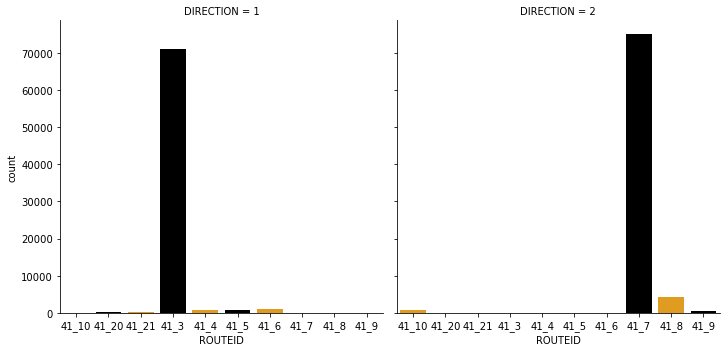

<Figure size 432x288 with 0 Axes>

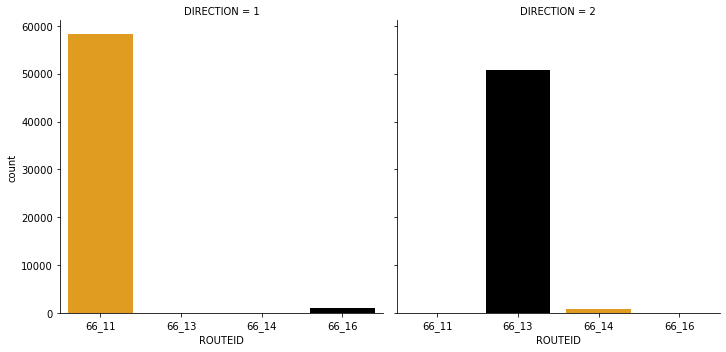

<Figure size 432x288 with 0 Axes>

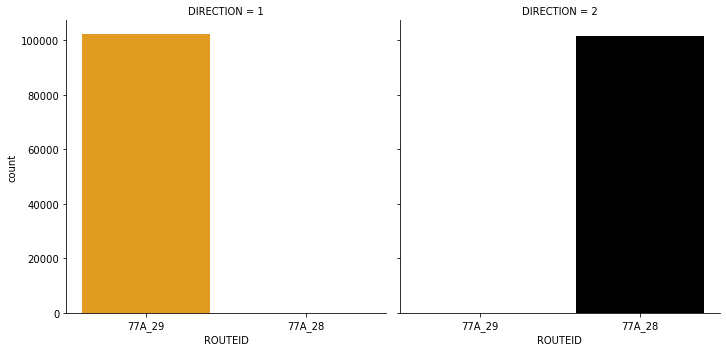

<Figure size 432x288 with 0 Axes>

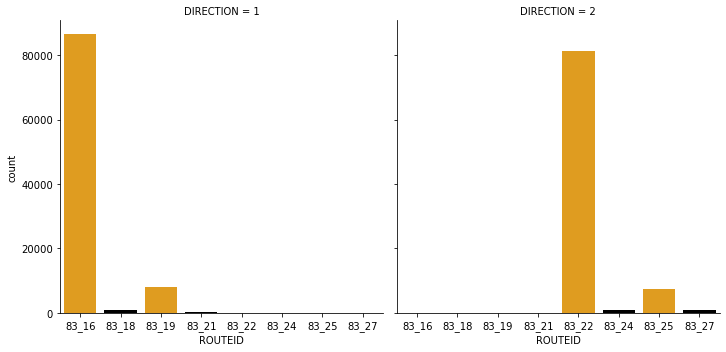

<Figure size 432x288 with 0 Axes>

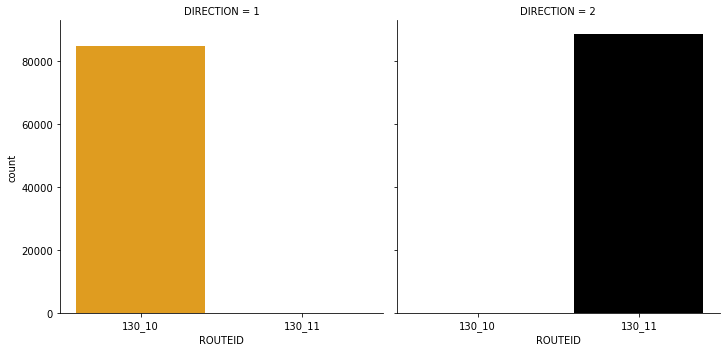

<Figure size 432x288 with 0 Axes>

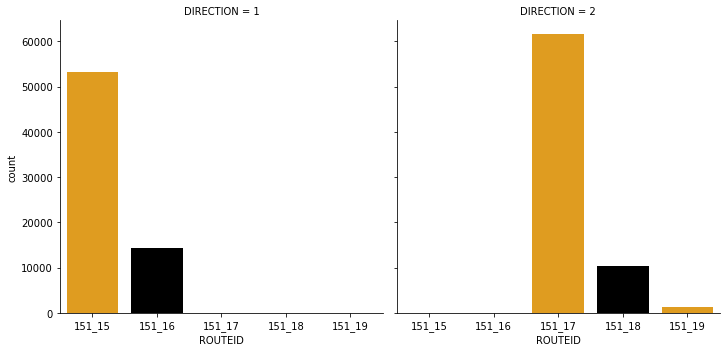

<Figure size 432x288 with 0 Axes>

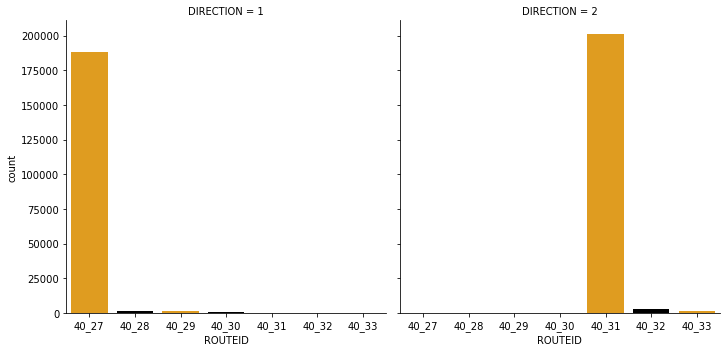

<Figure size 432x288 with 0 Axes>

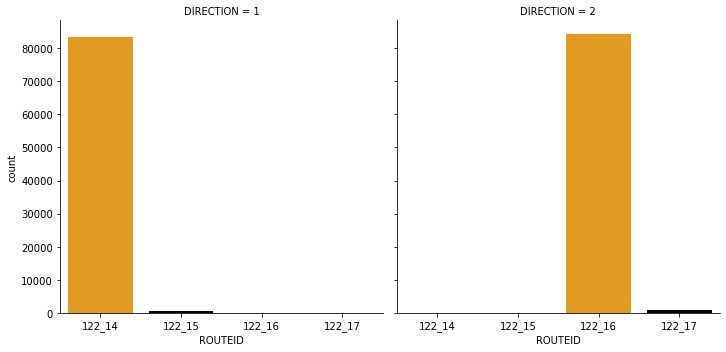

<Figure size 432x288 with 0 Axes>

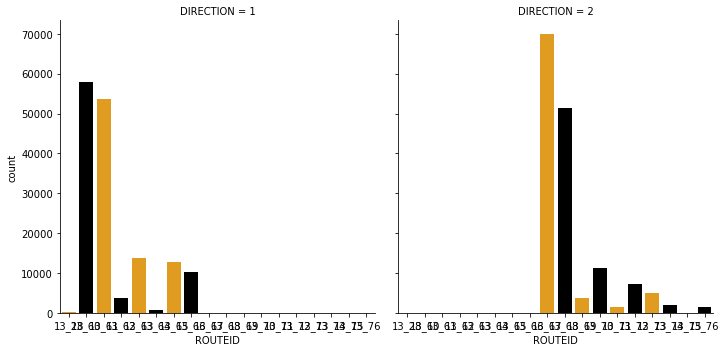

<Figure size 432x288 with 0 Axes>

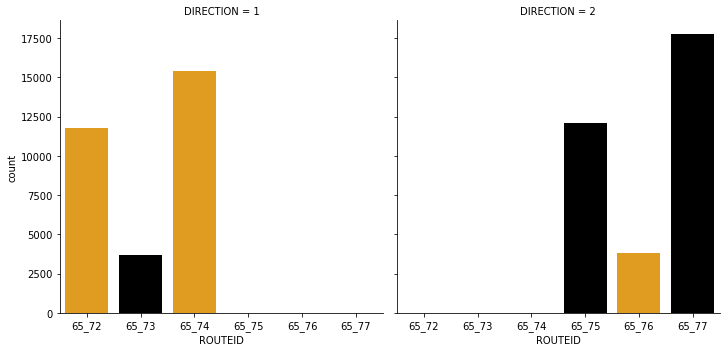

<Figure size 432x288 with 0 Axes>

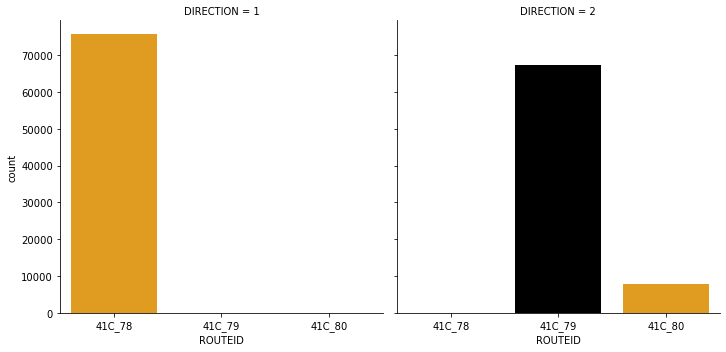

<Figure size 432x288 with 0 Axes>

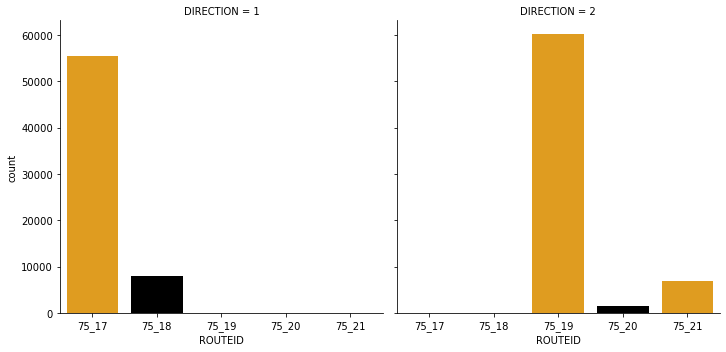

<Figure size 432x288 with 0 Axes>

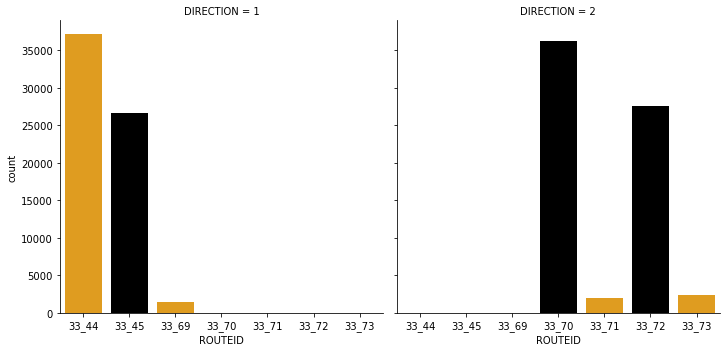

<Figure size 432x288 with 0 Axes>

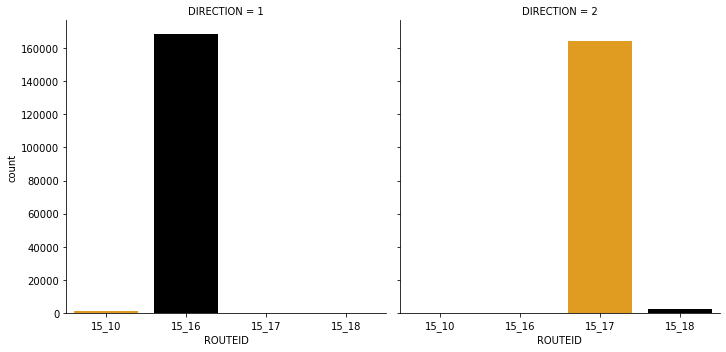

<Figure size 432x288 with 0 Axes>

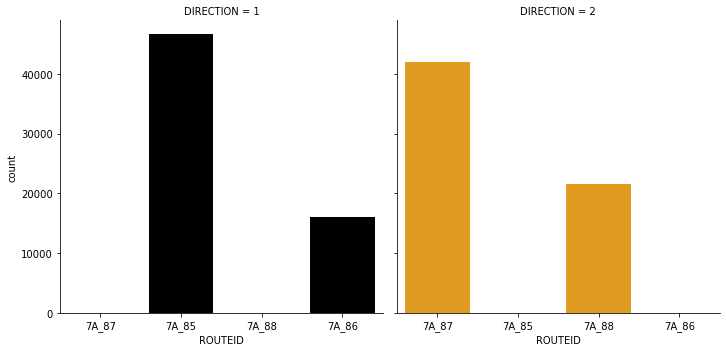

<Figure size 432x288 with 0 Axes>

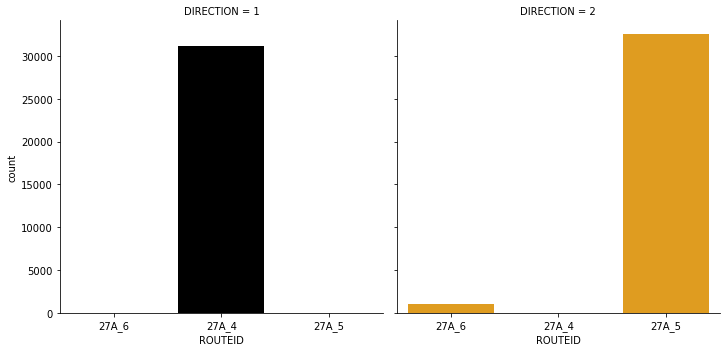

<Figure size 432x288 with 0 Axes>

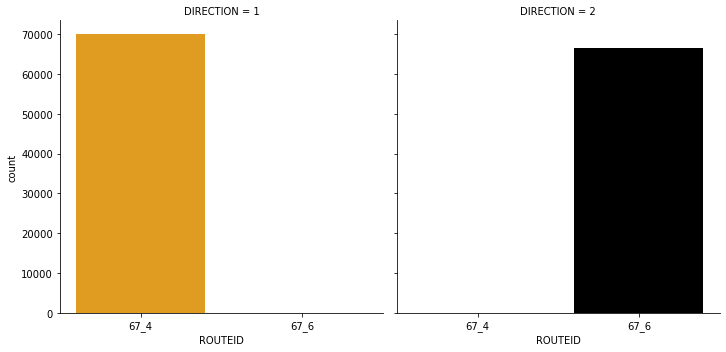

<Figure size 432x288 with 0 Axes>

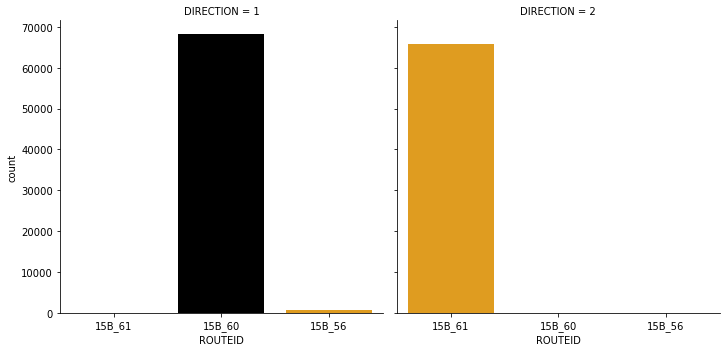

<Figure size 432x288 with 0 Axes>

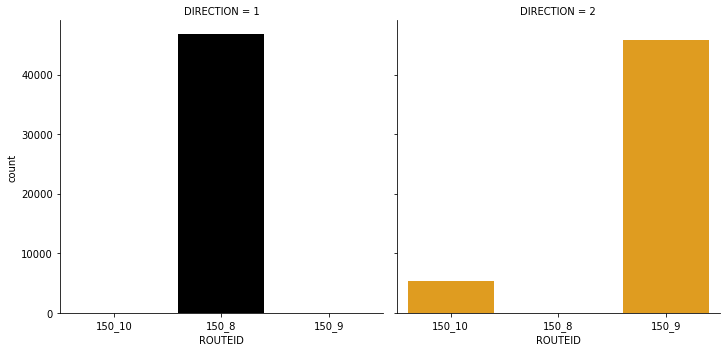

<Figure size 432x288 with 0 Axes>

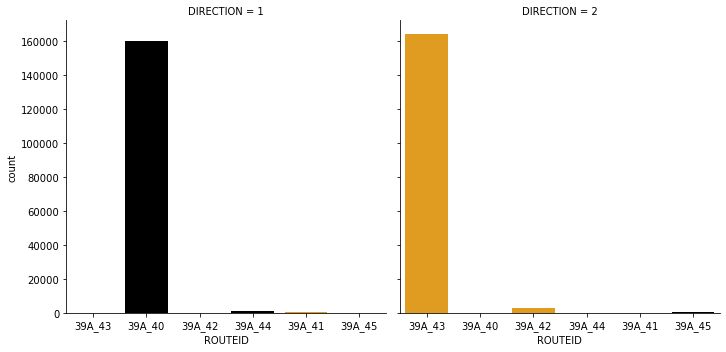

<Figure size 432x288 with 0 Axes>

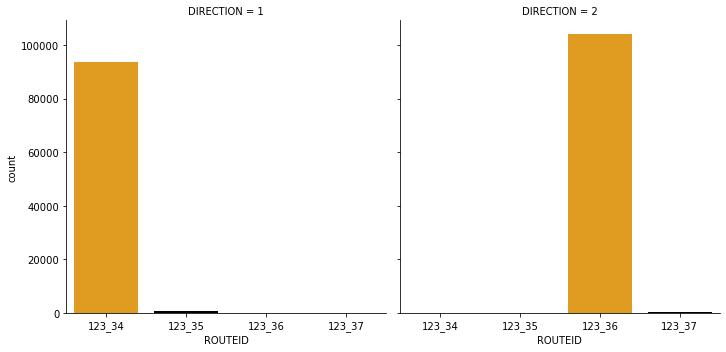

<Figure size 432x288 with 0 Axes>

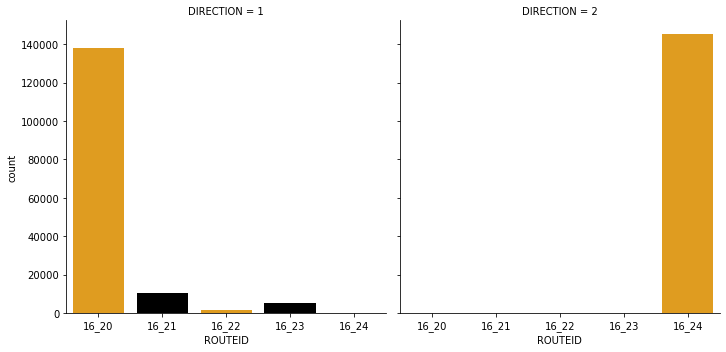

<Figure size 432x288 with 0 Axes>

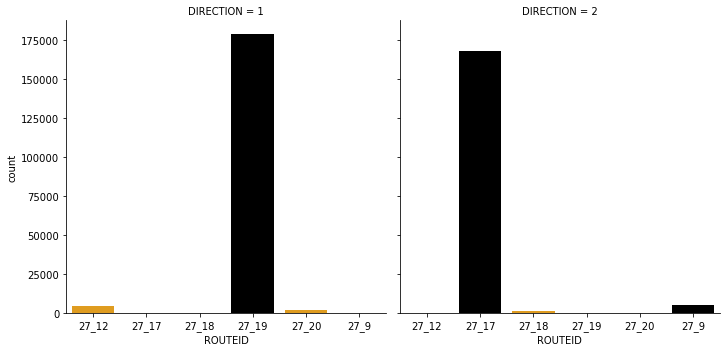

<Figure size 432x288 with 0 Axes>

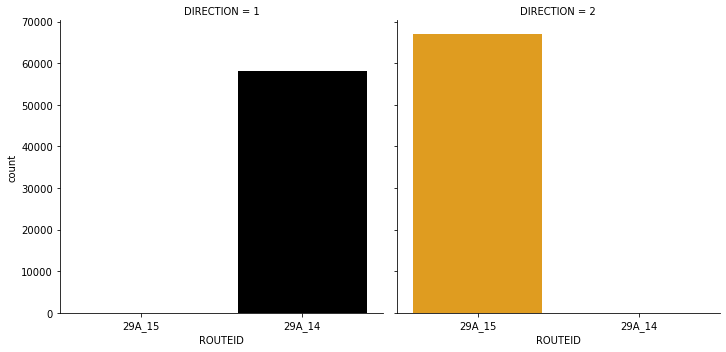

<Figure size 432x288 with 0 Axes>

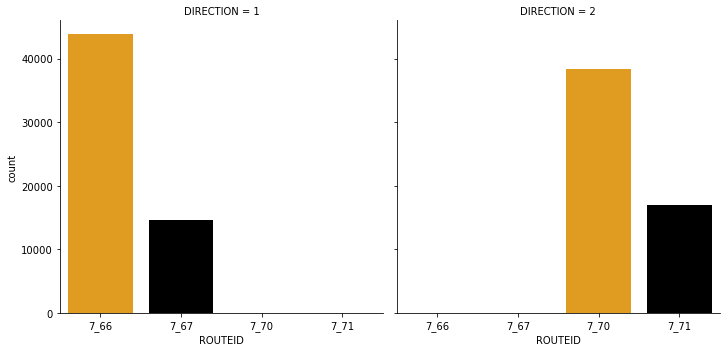

<Figure size 432x288 with 0 Axes>

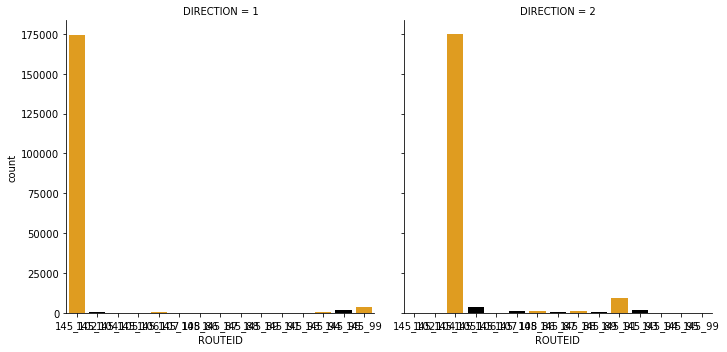

<Figure size 432x288 with 0 Axes>

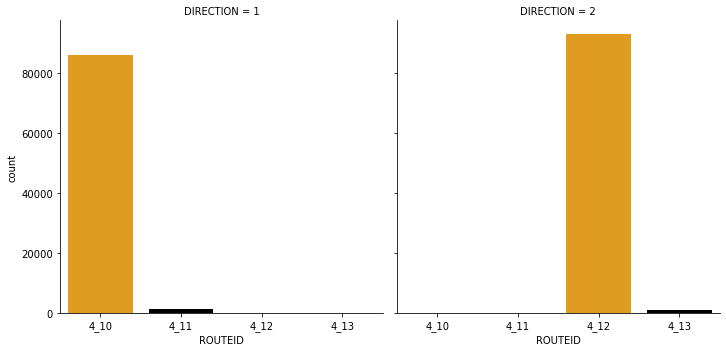

<Figure size 432x288 with 0 Axes>

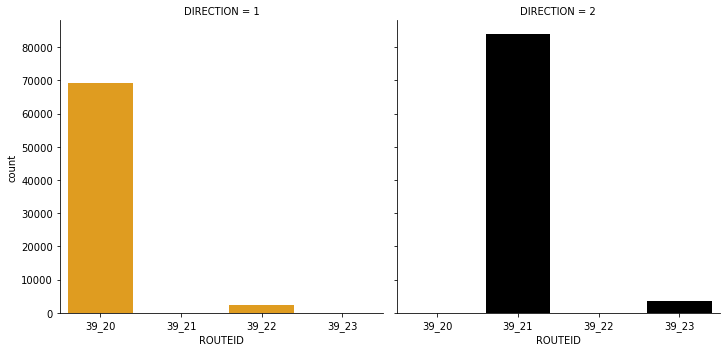

<Figure size 432x288 with 0 Axes>

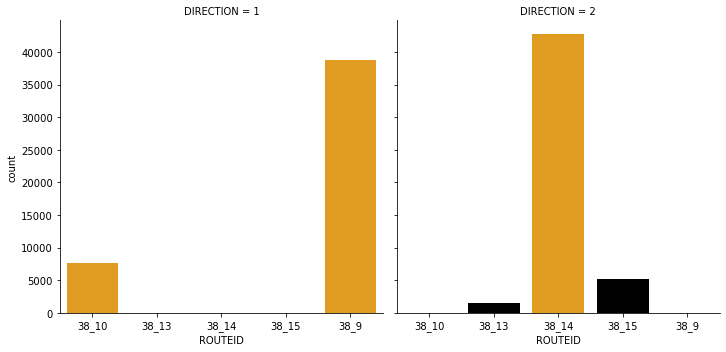

<Figure size 432x288 with 0 Axes>

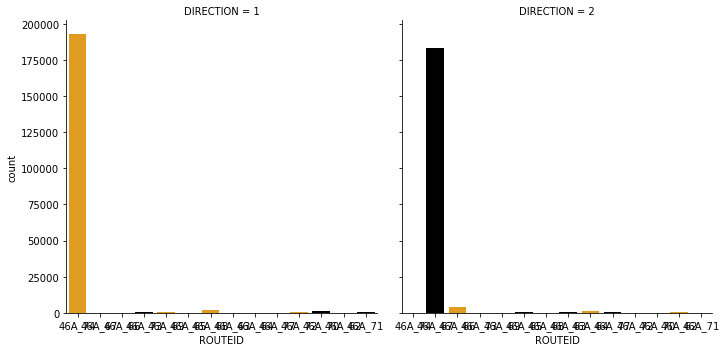

<Figure size 432x288 with 0 Axes>

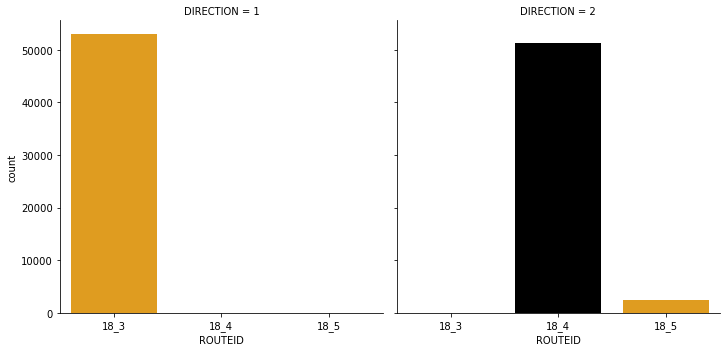

<Figure size 432x288 with 0 Axes>

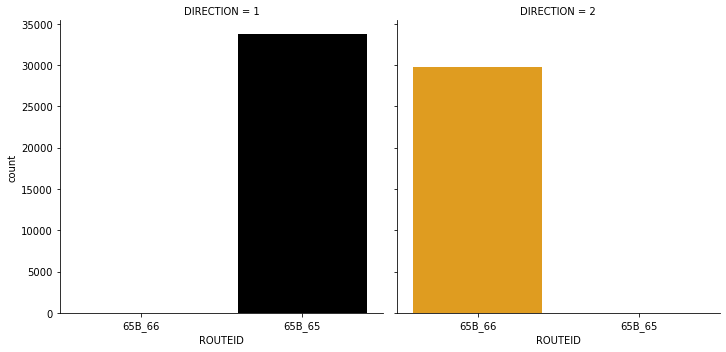

<Figure size 432x288 with 0 Axes>

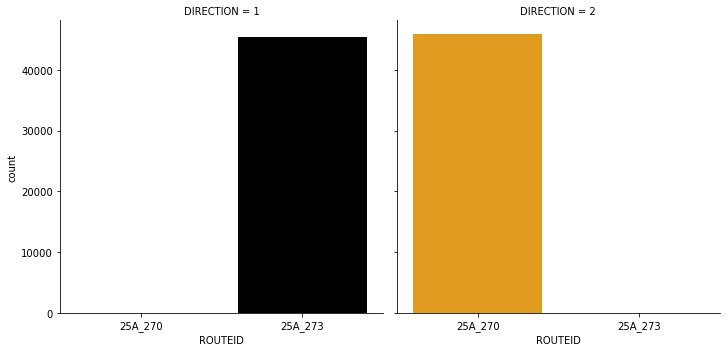

<Figure size 432x288 with 0 Axes>

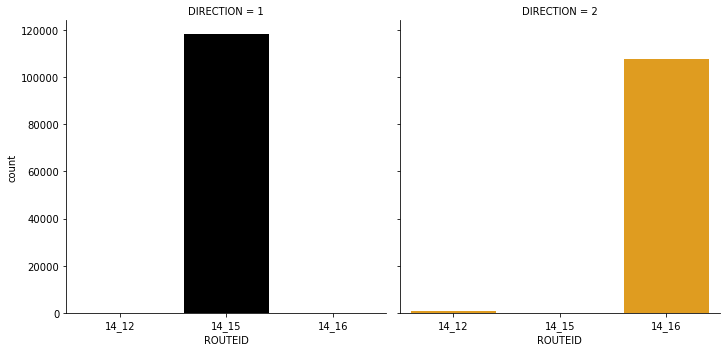

<Figure size 432x288 with 0 Axes>

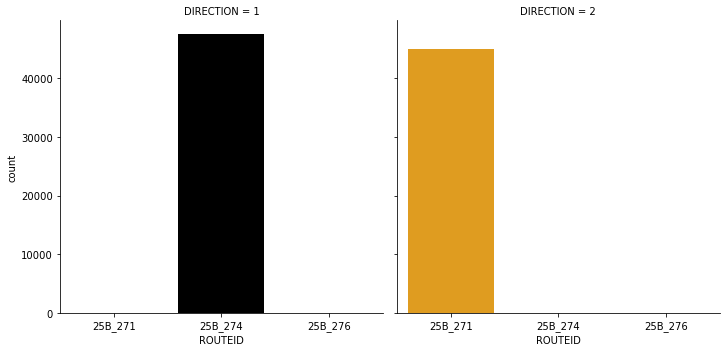

<Figure size 432x288 with 0 Axes>

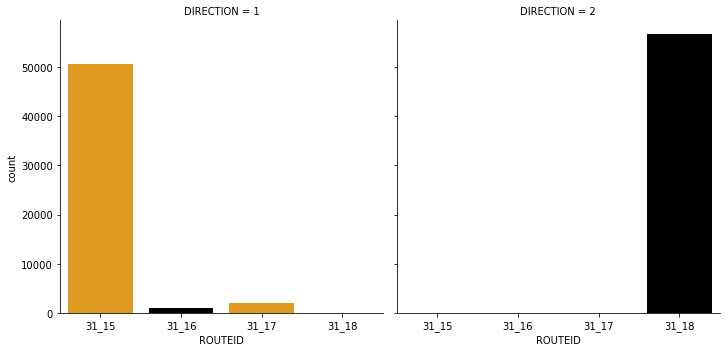

<Figure size 432x288 with 0 Axes>

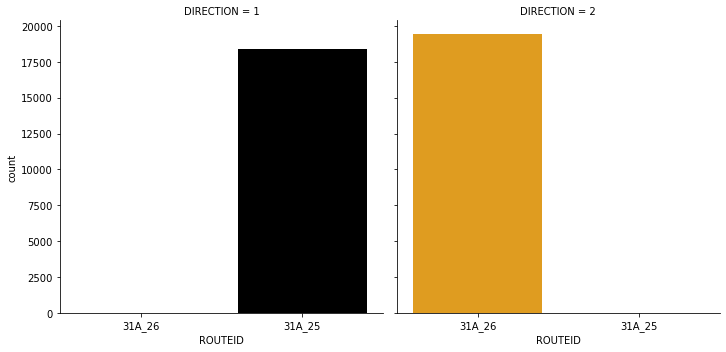

<Figure size 432x288 with 0 Axes>

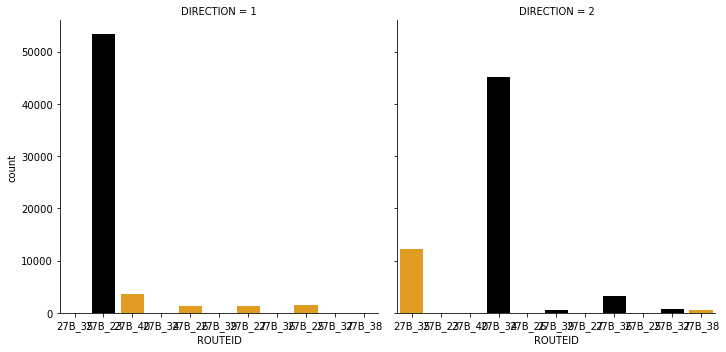

<Figure size 432x288 with 0 Axes>

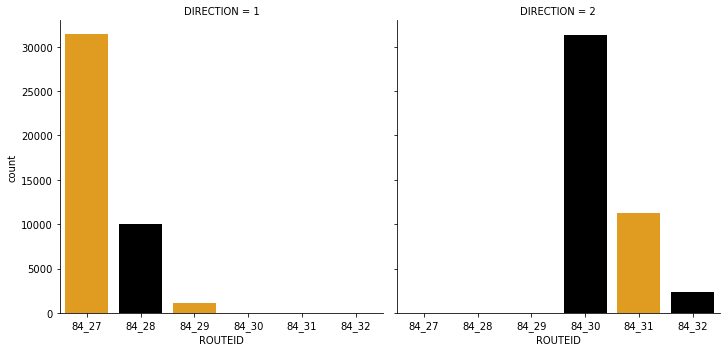

<Figure size 432x288 with 0 Axes>

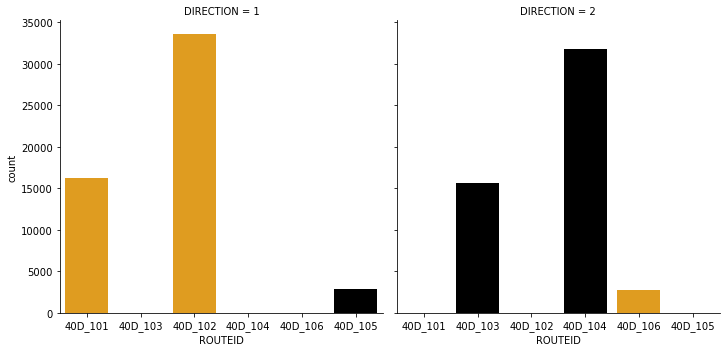

<Figure size 432x288 with 0 Axes>

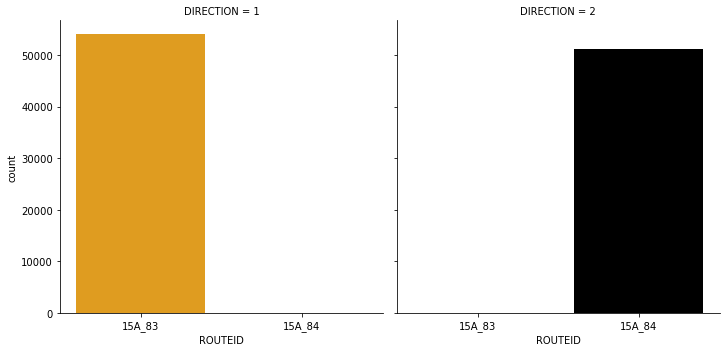

<Figure size 432x288 with 0 Axes>

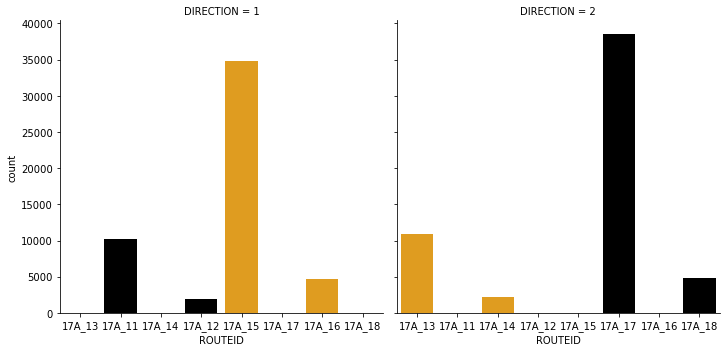

<Figure size 432x288 with 0 Axes>

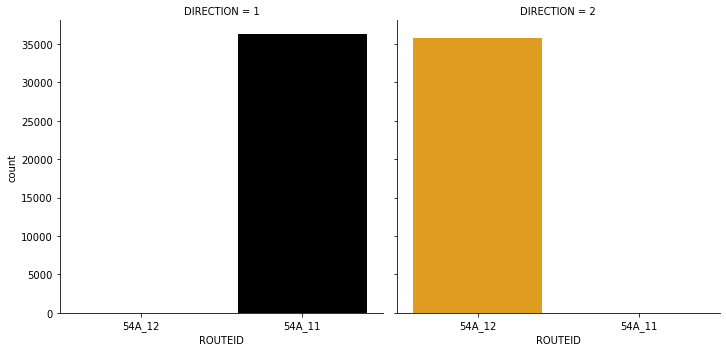

<Figure size 432x288 with 0 Axes>

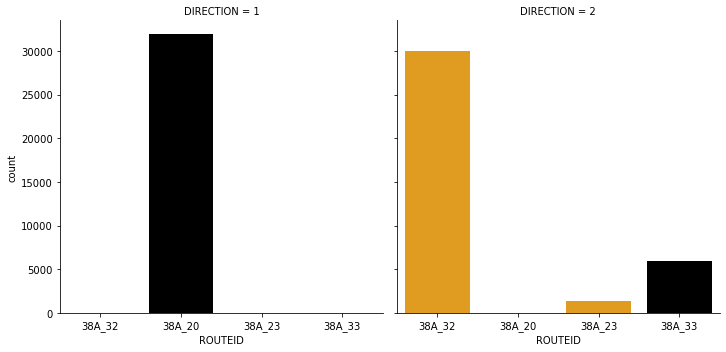

<Figure size 432x288 with 0 Axes>

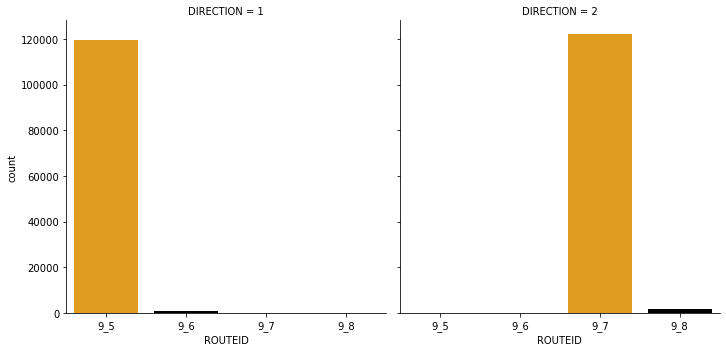

<Figure size 432x288 with 0 Axes>

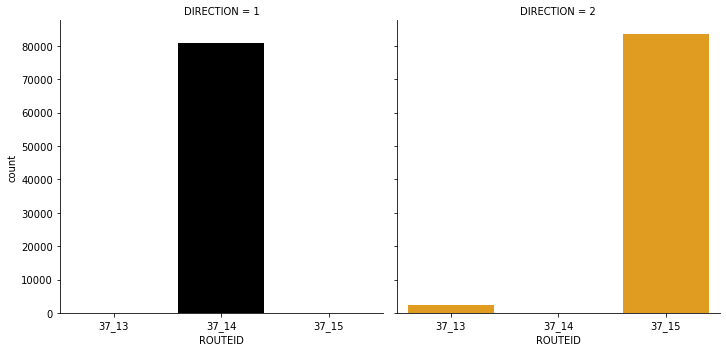

<Figure size 432x288 with 0 Axes>

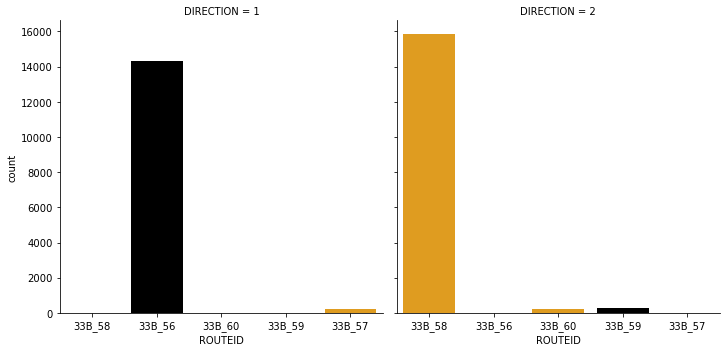

<Figure size 432x288 with 0 Axes>

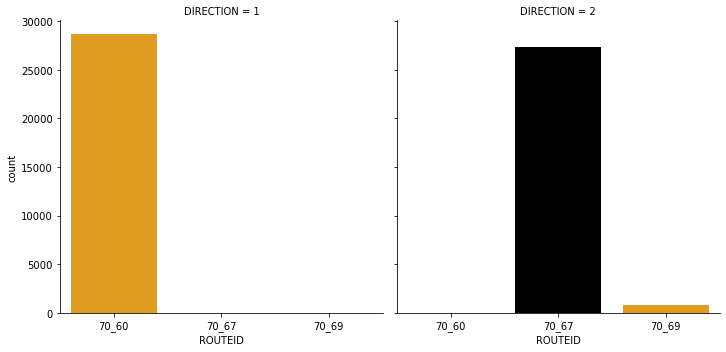

<Figure size 432x288 with 0 Axes>

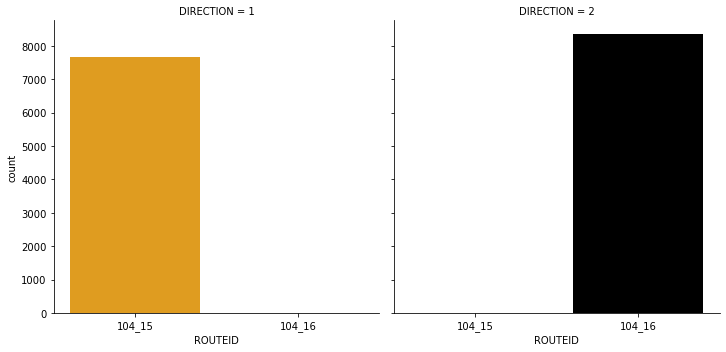

<Figure size 432x288 with 0 Axes>

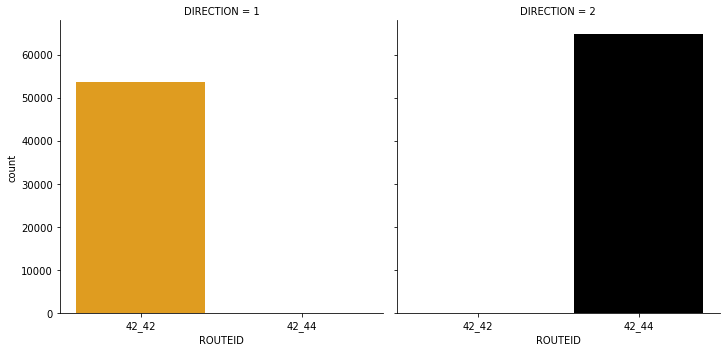

<Figure size 432x288 with 0 Axes>

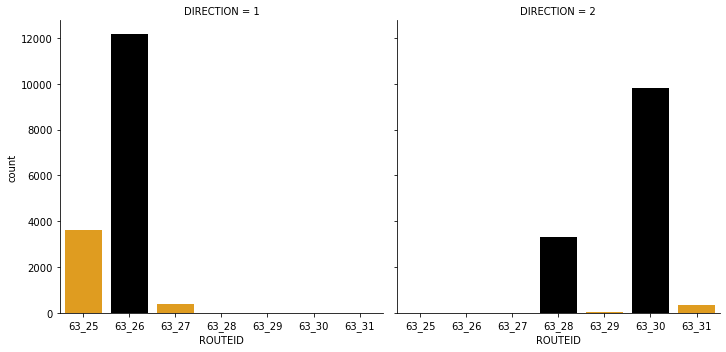

<Figure size 432x288 with 0 Axes>

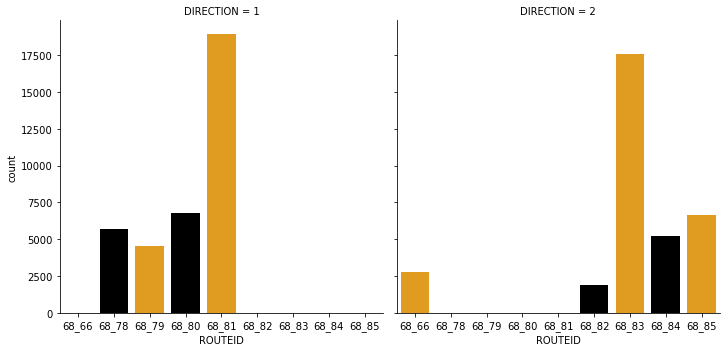

<Figure size 432x288 with 0 Axes>

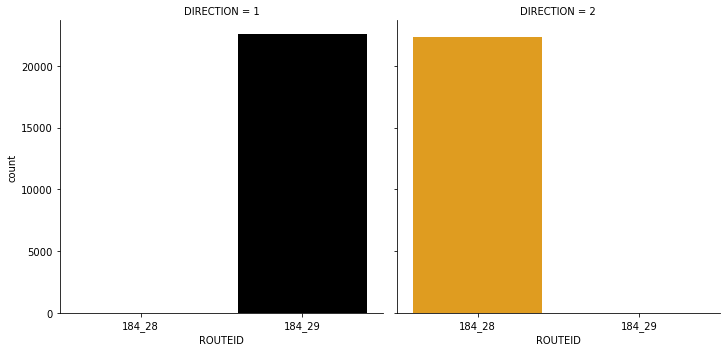

<Figure size 432x288 with 0 Axes>

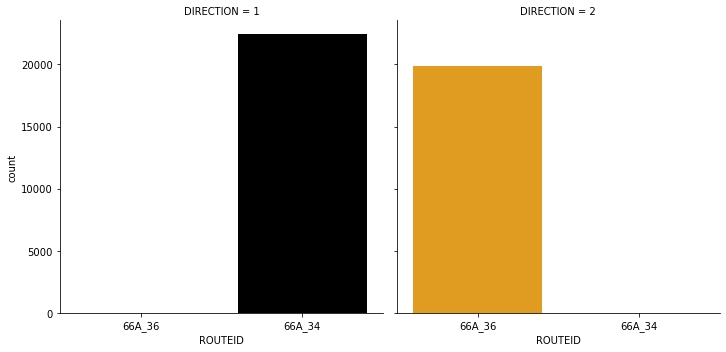

<Figure size 432x288 with 0 Axes>

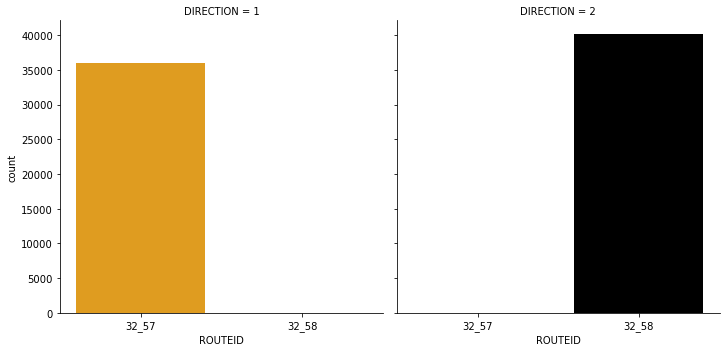

<Figure size 432x288 with 0 Axes>

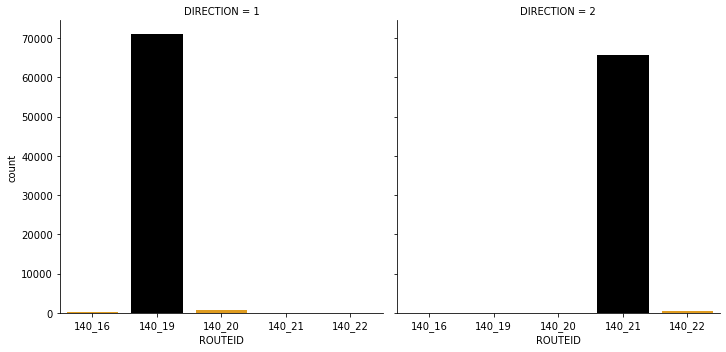

<Figure size 432x288 with 0 Axes>

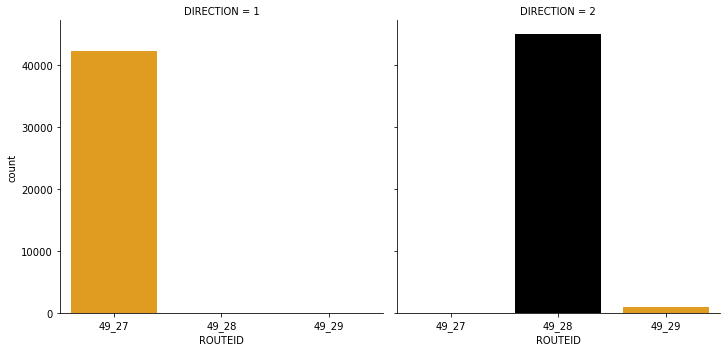

<Figure size 432x288 with 0 Axes>

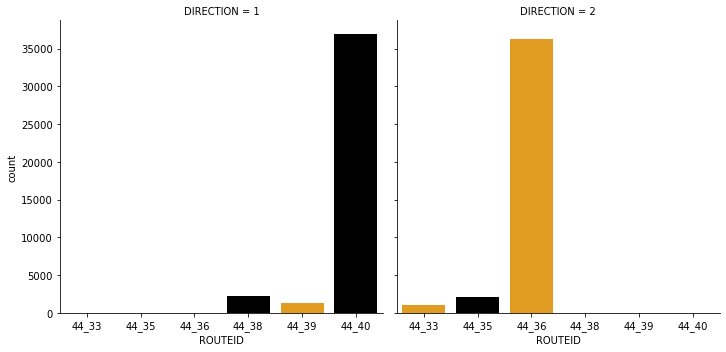

<Figure size 432x288 with 0 Axes>

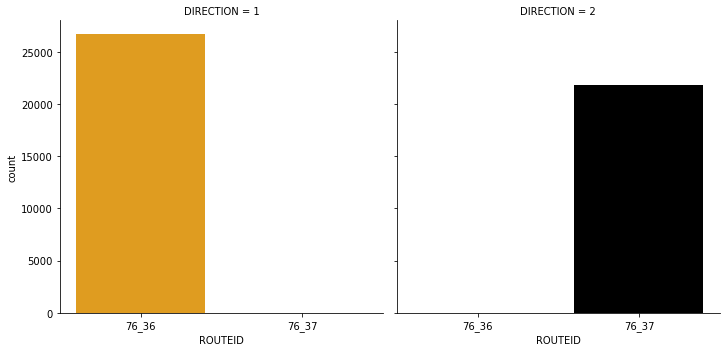

<Figure size 432x288 with 0 Axes>

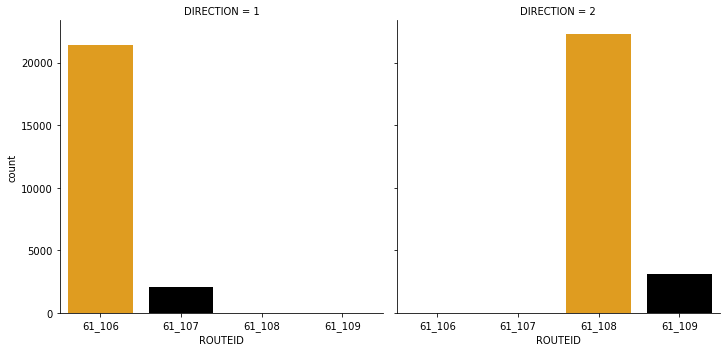

<Figure size 432x288 with 0 Axes>

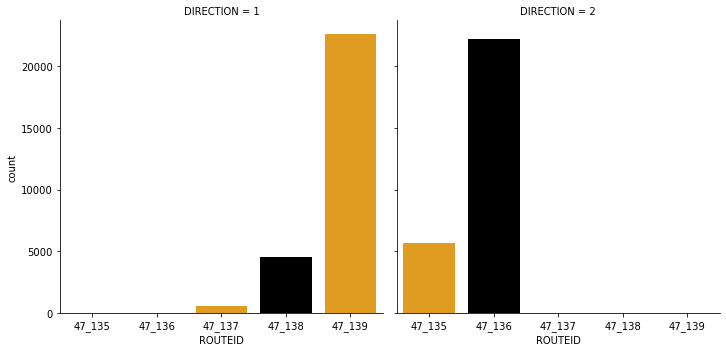

<Figure size 432x288 with 0 Axes>

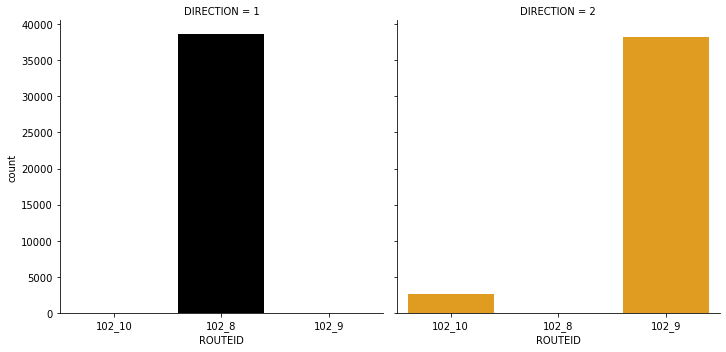

<Figure size 432x288 with 0 Axes>

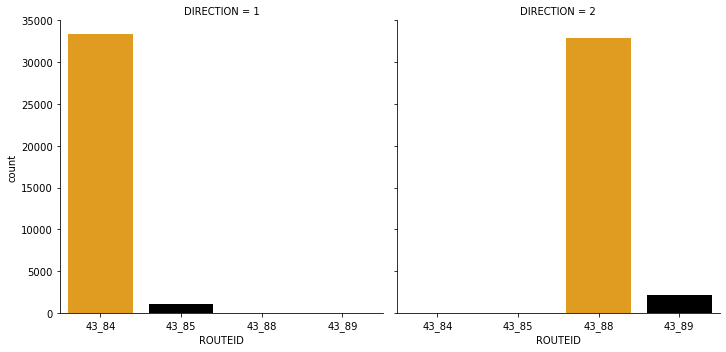

<Figure size 432x288 with 0 Axes>

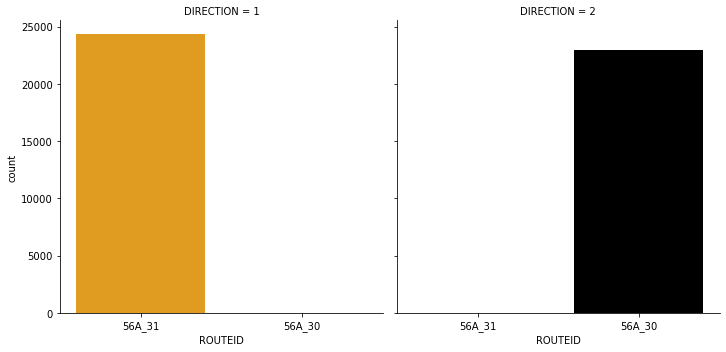

<Figure size 432x288 with 0 Axes>

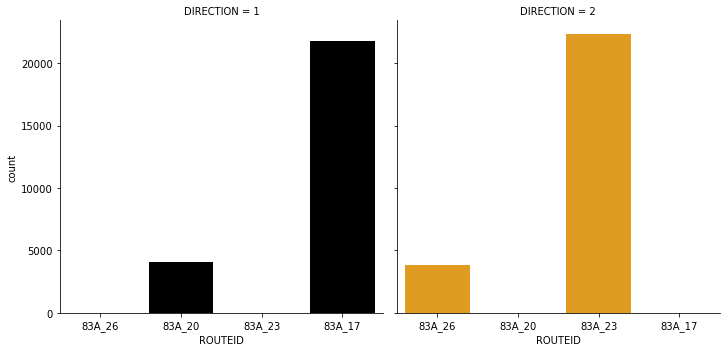

<Figure size 432x288 with 0 Axes>

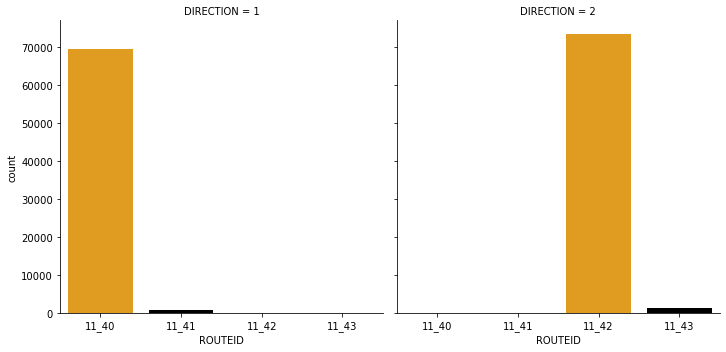

<Figure size 432x288 with 0 Axes>

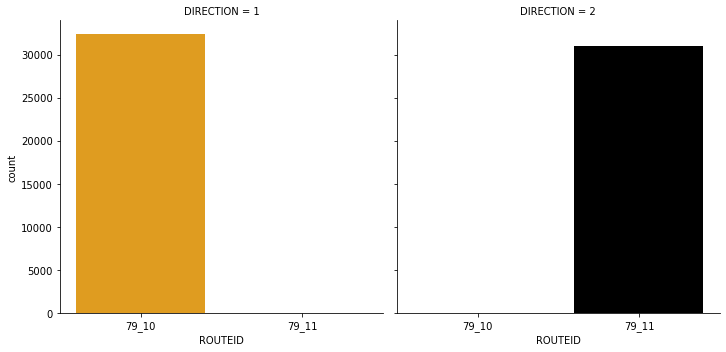

<Figure size 432x288 with 0 Axes>

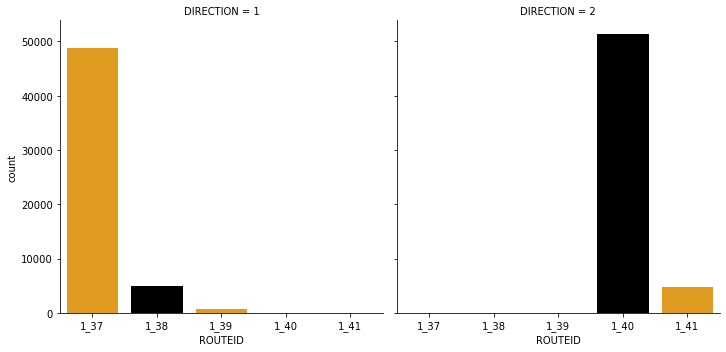

<Figure size 432x288 with 0 Axes>

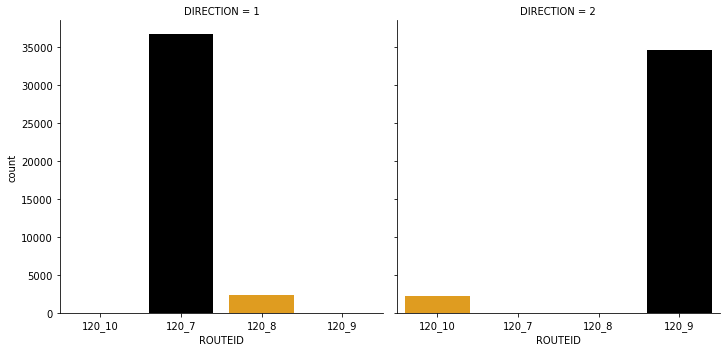

<Figure size 432x288 with 0 Axes>

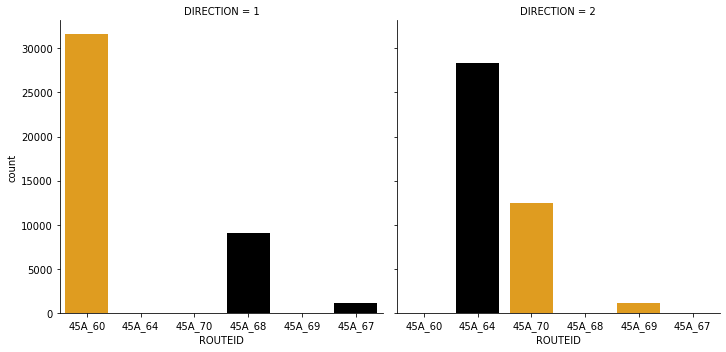

<Figure size 432x288 with 0 Axes>

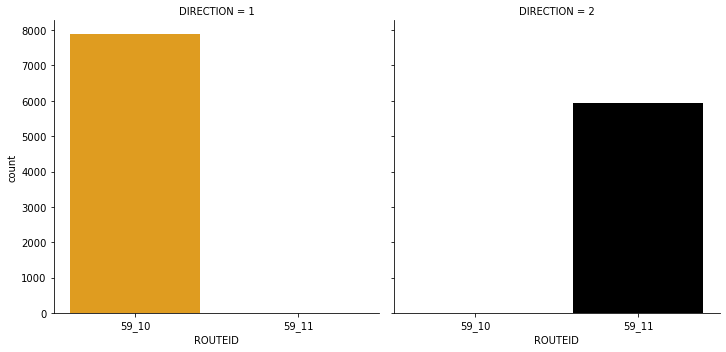

<Figure size 432x288 with 0 Axes>

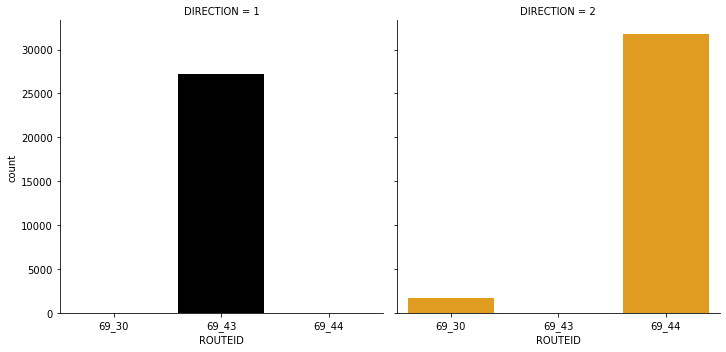

<Figure size 432x288 with 0 Axes>

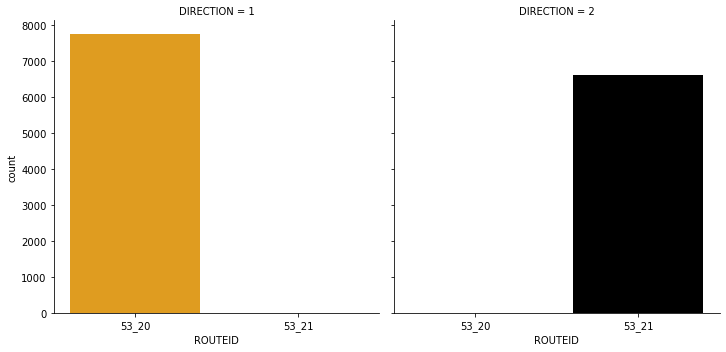

<Figure size 432x288 with 0 Axes>

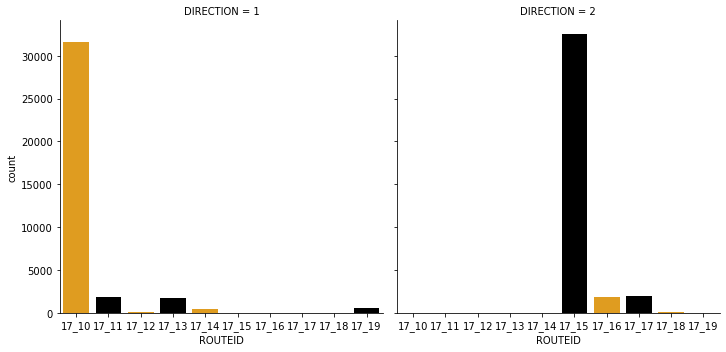

<Figure size 432x288 with 0 Axes>

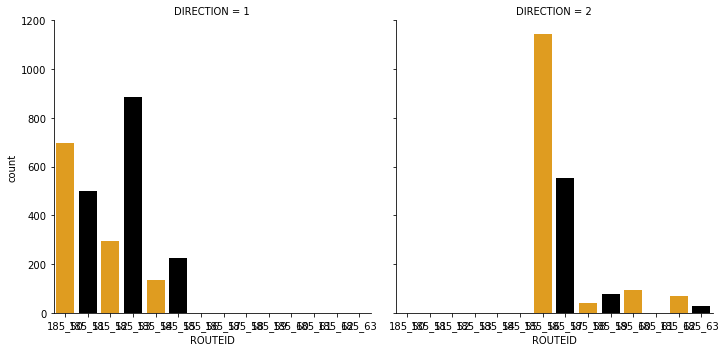

<Figure size 432x288 with 0 Axes>

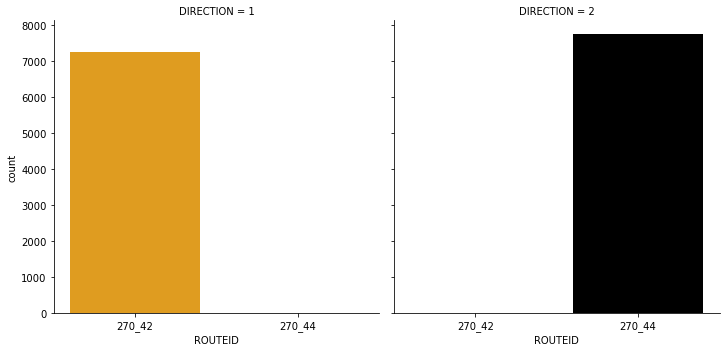

<Figure size 432x288 with 0 Axes>

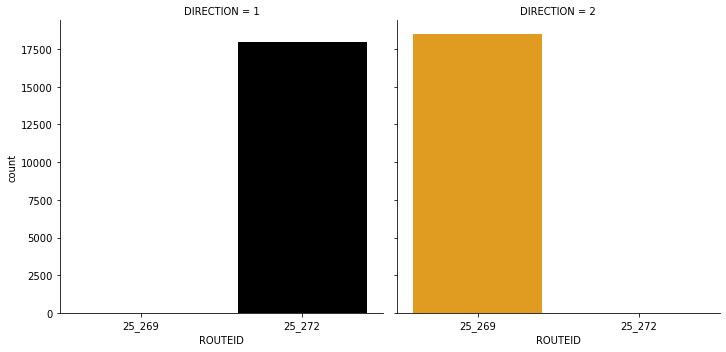

<Figure size 432x288 with 0 Axes>

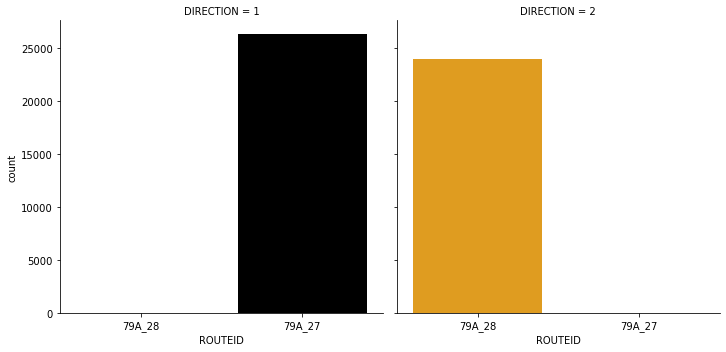

<Figure size 432x288 with 0 Axes>

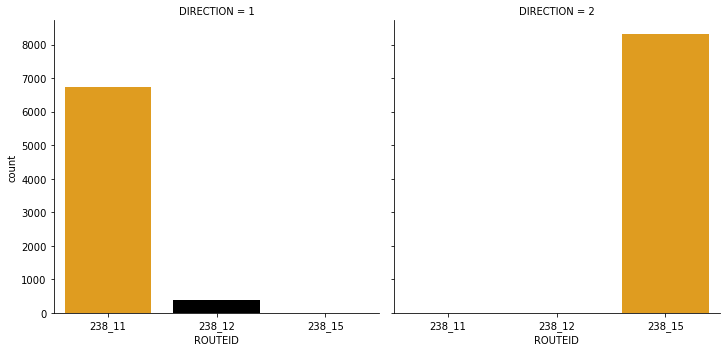

<Figure size 432x288 with 0 Axes>

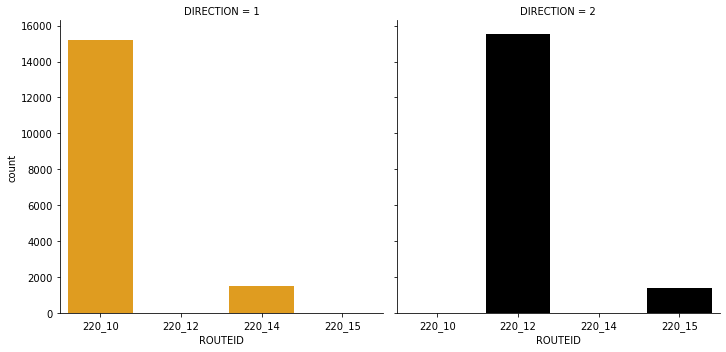

<Figure size 432x288 with 0 Axes>

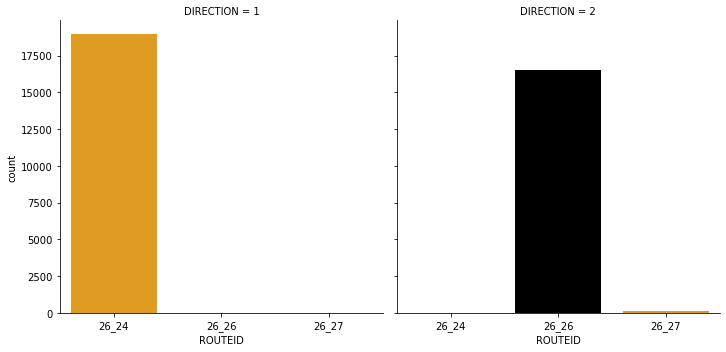

<Figure size 432x288 with 0 Axes>

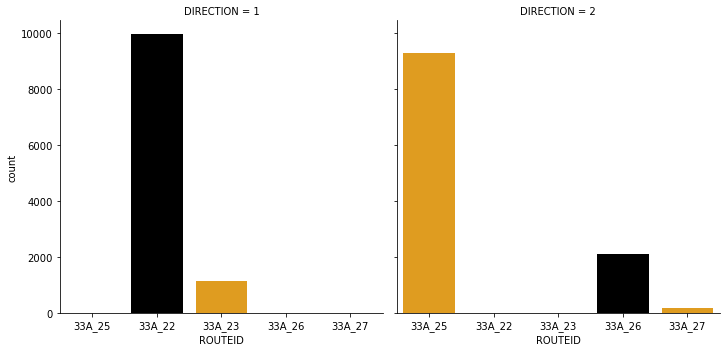

<Figure size 432x288 with 0 Axes>

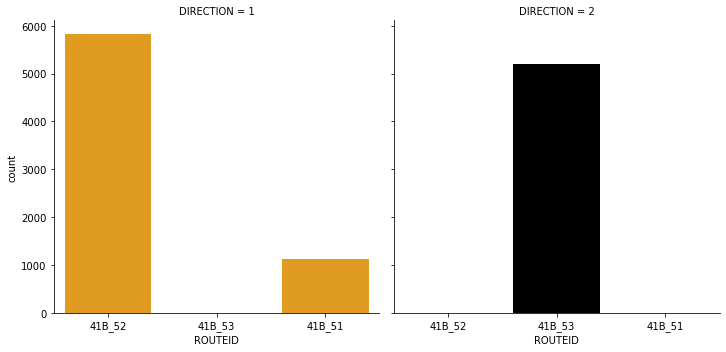

<Figure size 432x288 with 0 Axes>

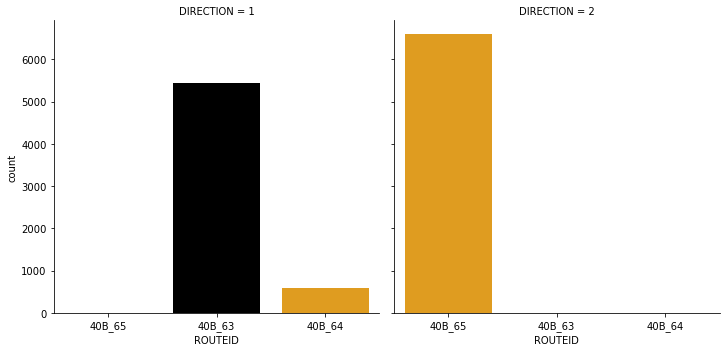

<Figure size 432x288 with 0 Axes>

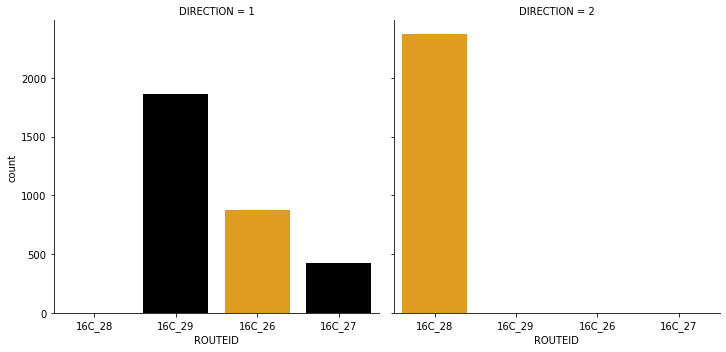

<Figure size 432x288 with 0 Axes>

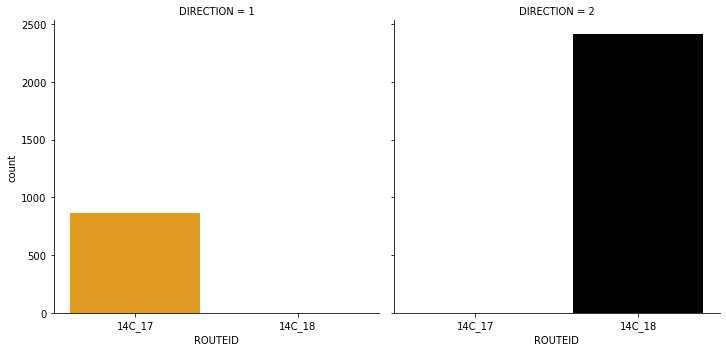

<Figure size 432x288 with 0 Axes>

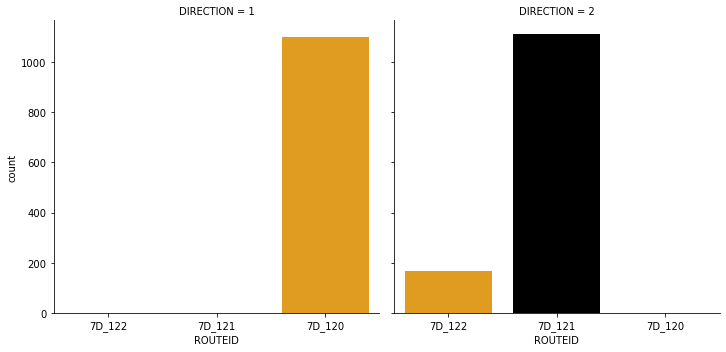

<Figure size 432x288 with 0 Axes>

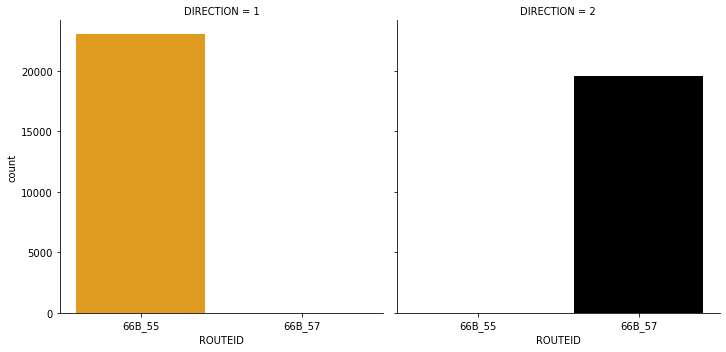

<Figure size 432x288 with 0 Axes>

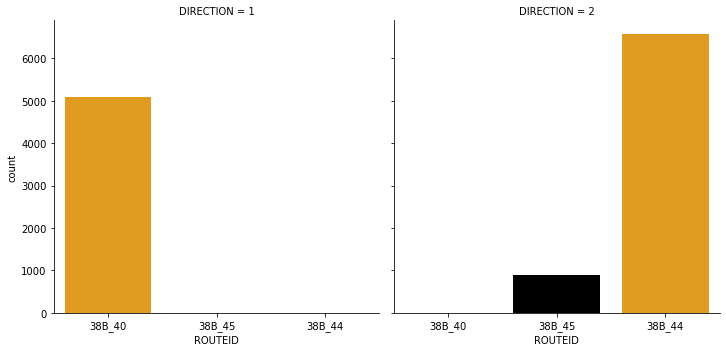

<Figure size 432x288 with 0 Axes>

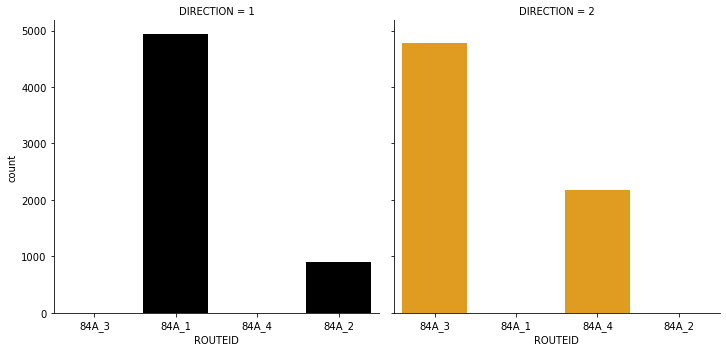

<Figure size 432x288 with 0 Axes>

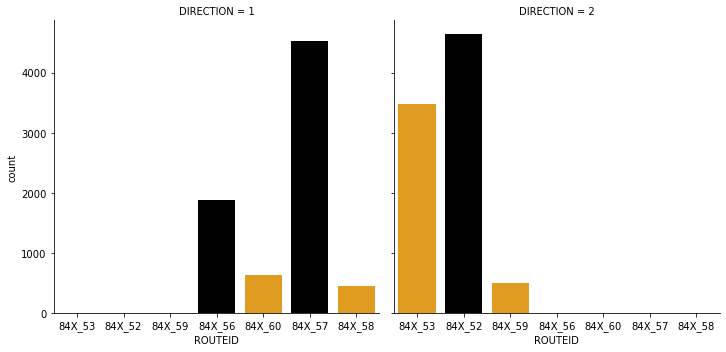

<Figure size 432x288 with 0 Axes>

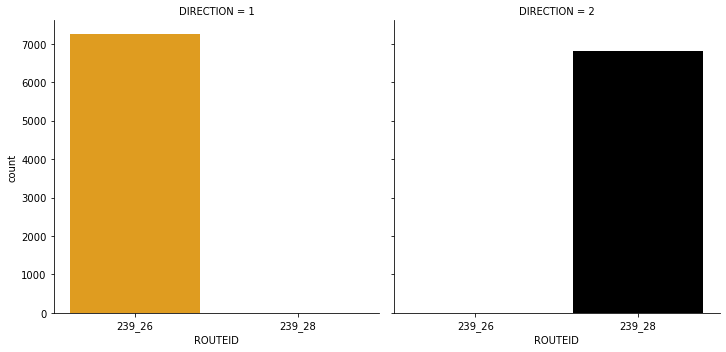

<Figure size 432x288 with 0 Axes>

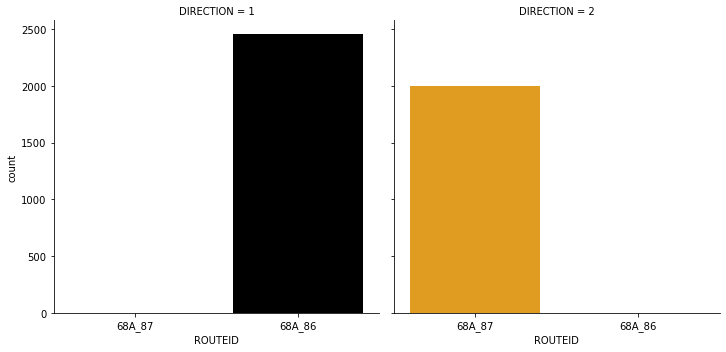

<Figure size 432x288 with 0 Axes>

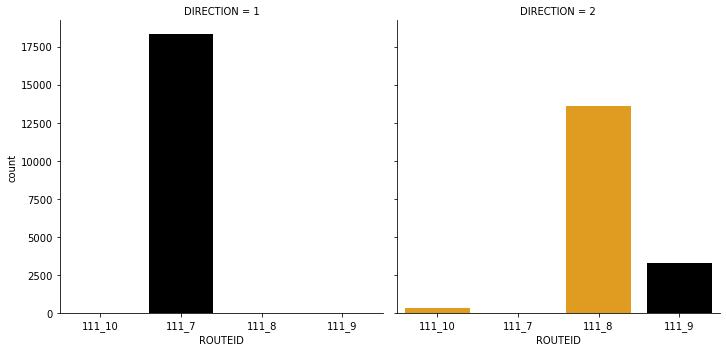

<Figure size 432x288 with 0 Axes>

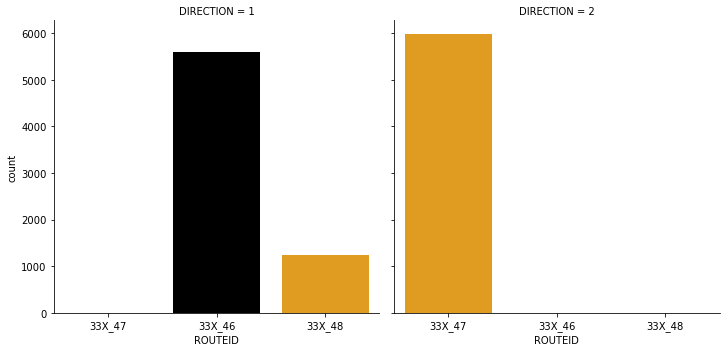

<Figure size 432x288 with 0 Axes>

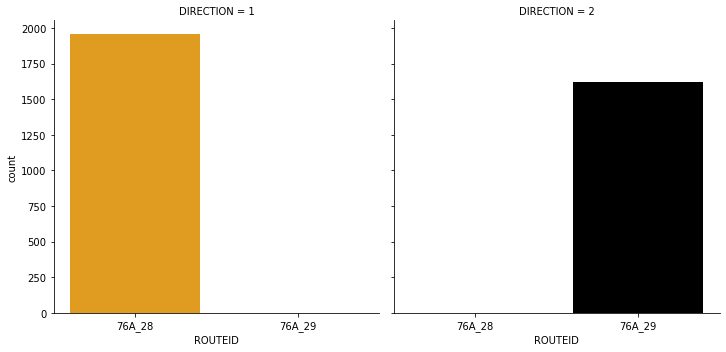

<Figure size 432x288 with 0 Axes>

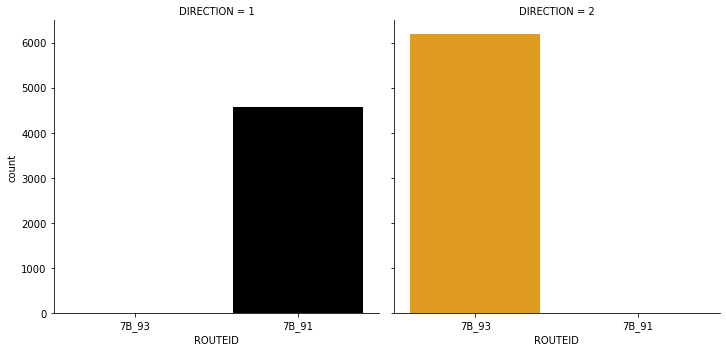

<Figure size 432x288 with 0 Axes>

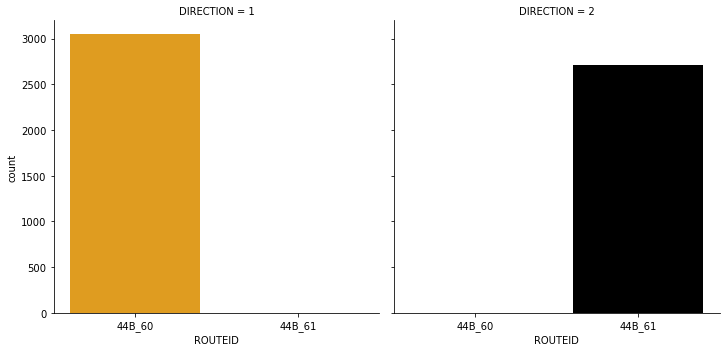

<Figure size 432x288 with 0 Axes>

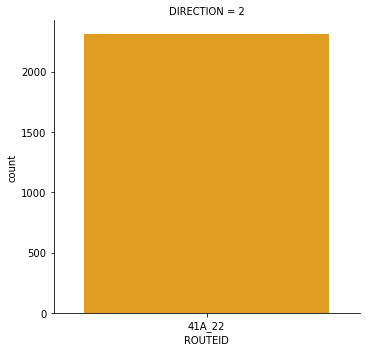

<Figure size 432x288 with 0 Axes>

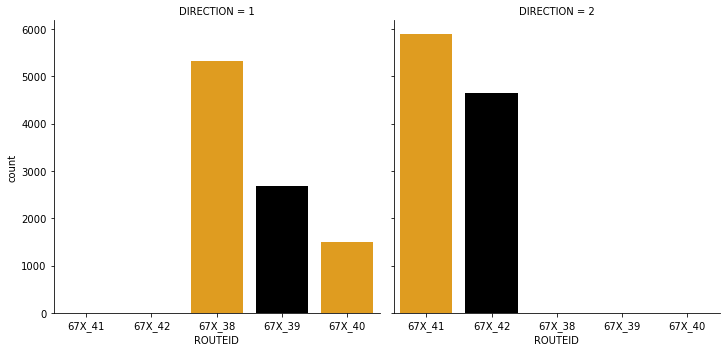

<Figure size 432x288 with 0 Axes>

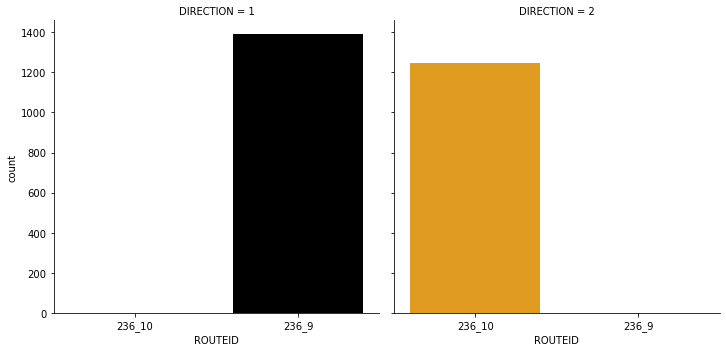

<Figure size 432x288 with 0 Axes>

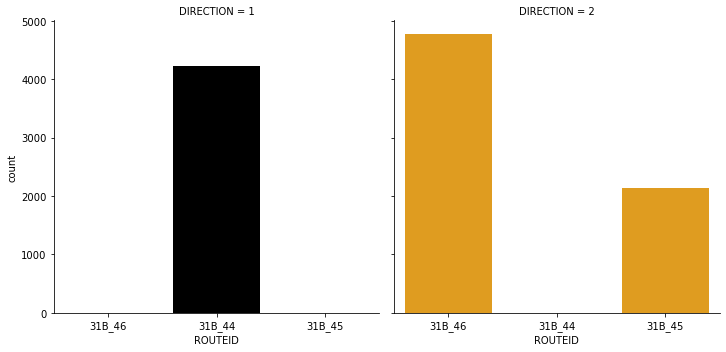

<Figure size 432x288 with 0 Axes>

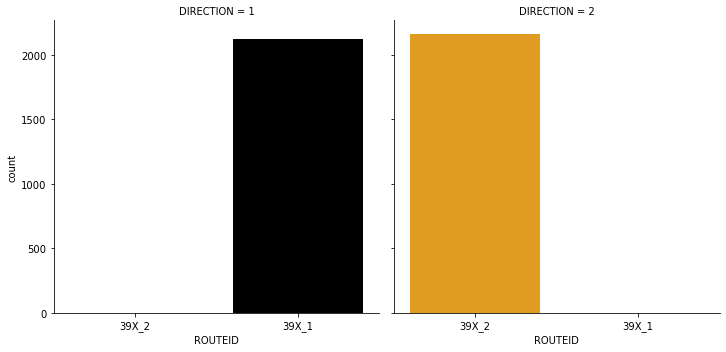

<Figure size 432x288 with 0 Axes>

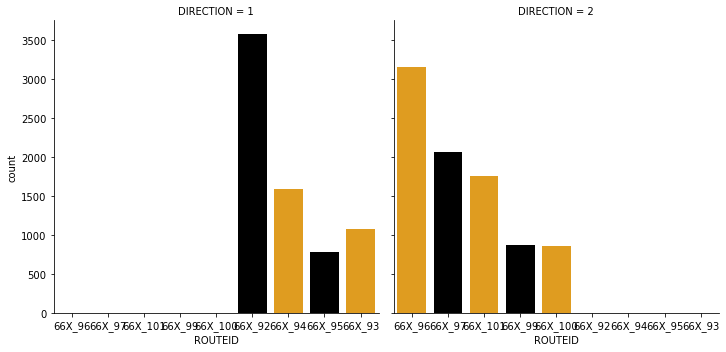

<Figure size 432x288 with 0 Axes>

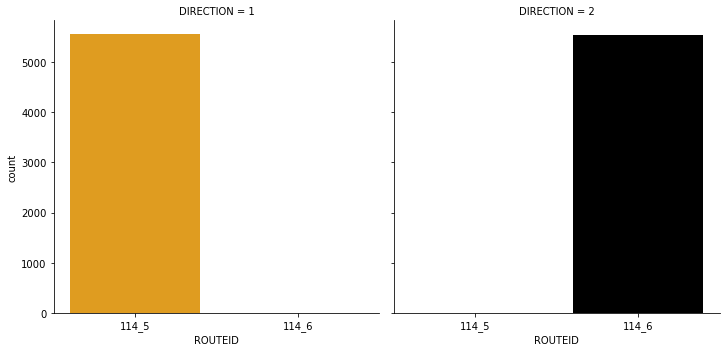

<Figure size 432x288 with 0 Axes>

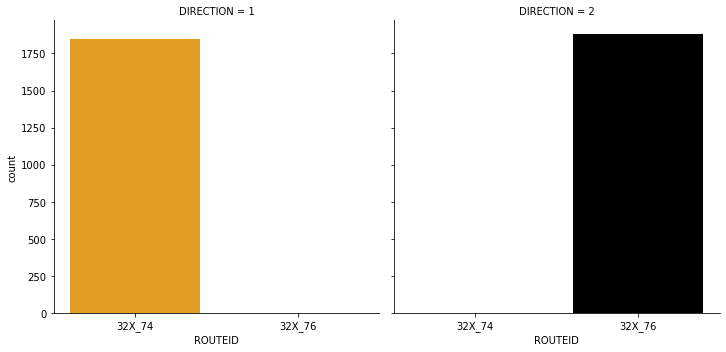

<Figure size 432x288 with 0 Axes>

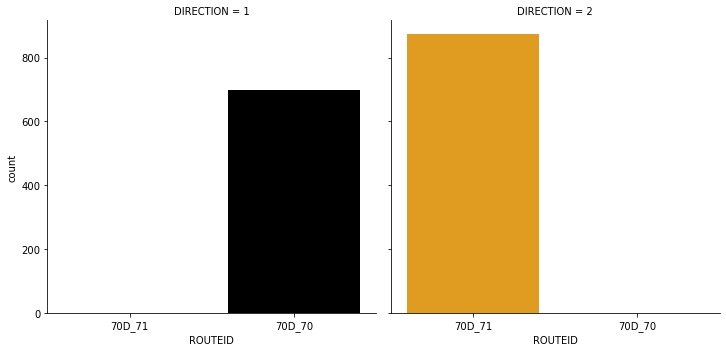

<Figure size 432x288 with 0 Axes>

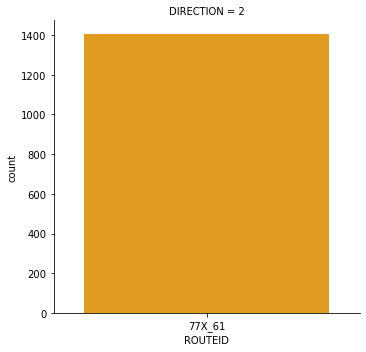

<Figure size 432x288 with 0 Axes>

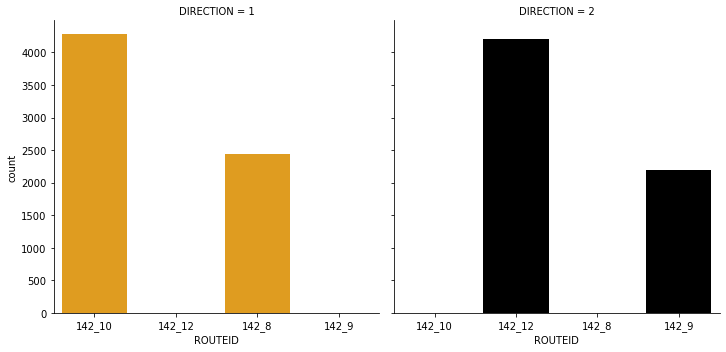

<Figure size 432x288 with 0 Axes>

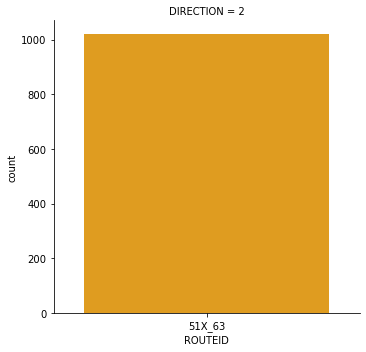

<Figure size 432x288 with 0 Axes>

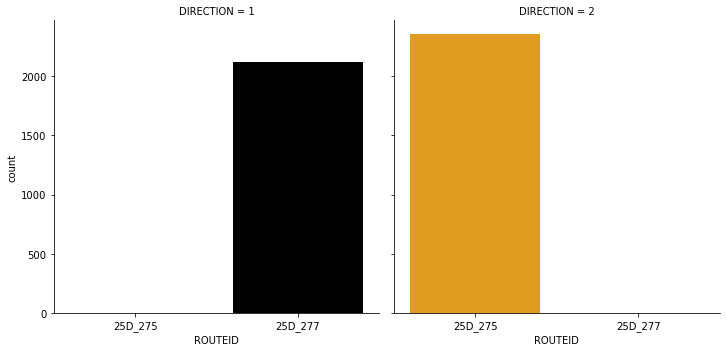

<Figure size 432x288 with 0 Axes>

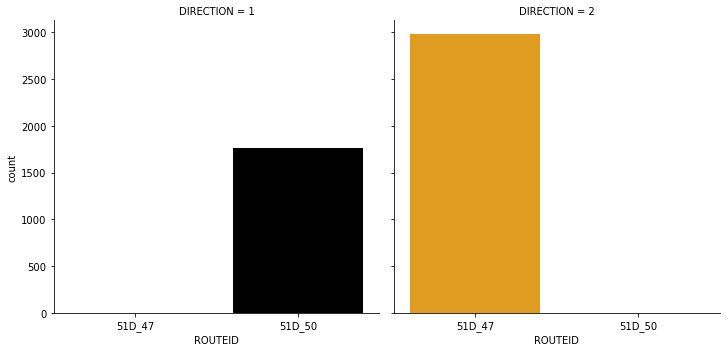

<Figure size 432x288 with 0 Axes>

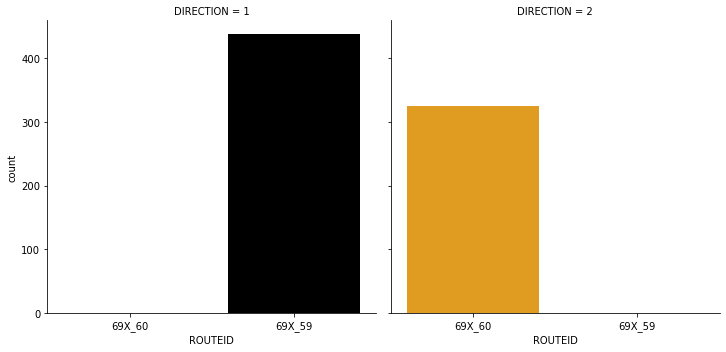

<Figure size 432x288 with 0 Axes>

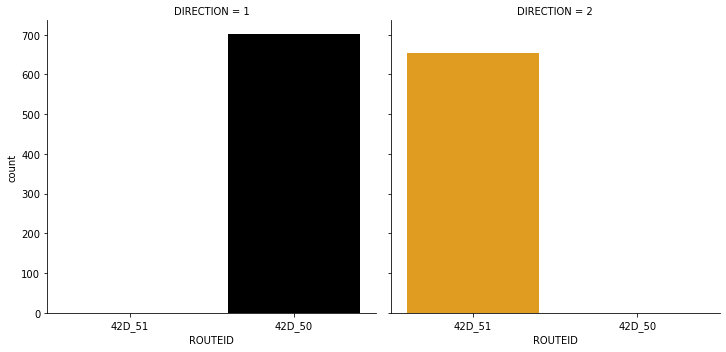

<Figure size 432x288 with 0 Axes>

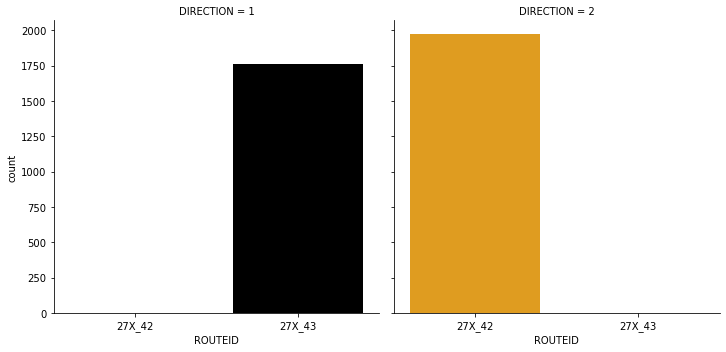

<Figure size 432x288 with 0 Axes>

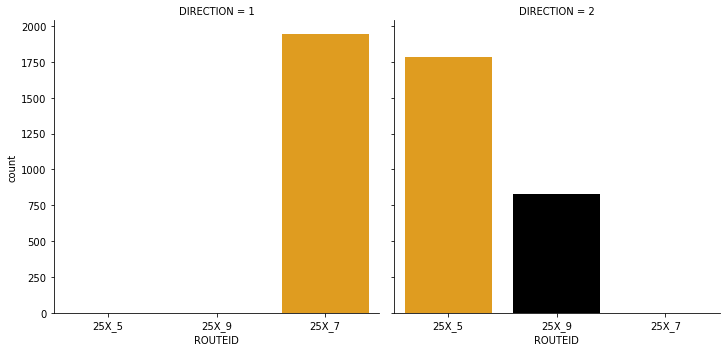

<Figure size 432x288 with 0 Axes>

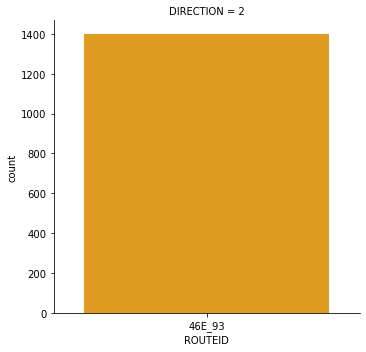

<Figure size 432x288 with 0 Axes>

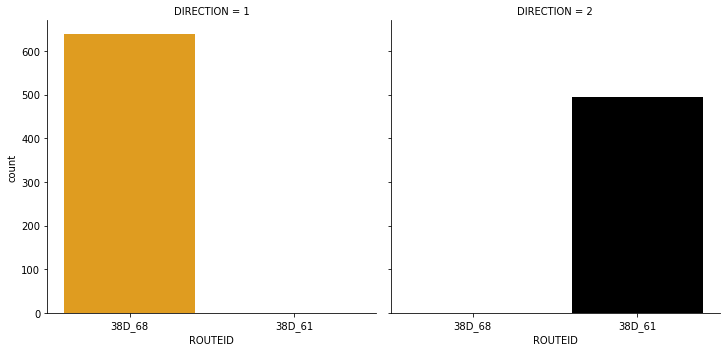

<Figure size 432x288 with 0 Axes>

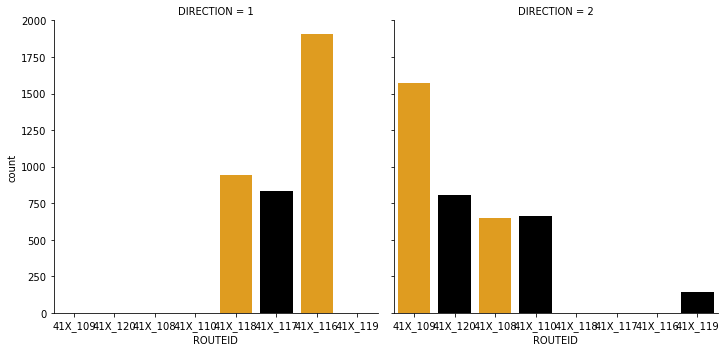

<Figure size 432x288 with 0 Axes>

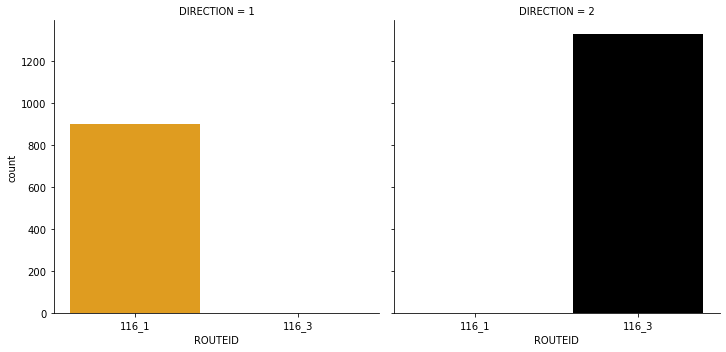

<Figure size 432x288 with 0 Axes>

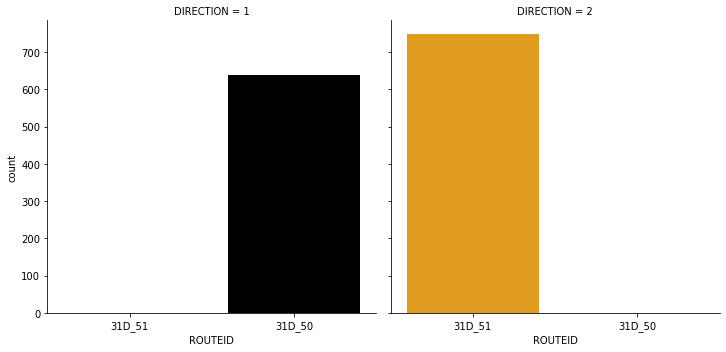

<Figure size 432x288 with 0 Axes>

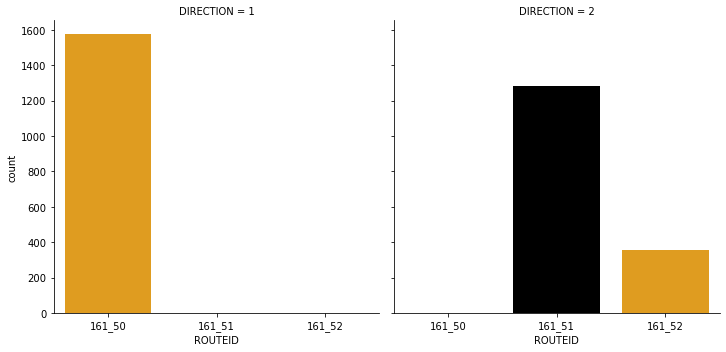

<Figure size 432x288 with 0 Axes>

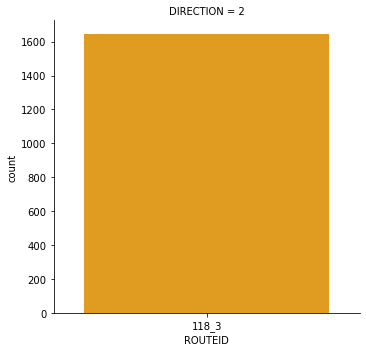

<Figure size 432x288 with 0 Axes>

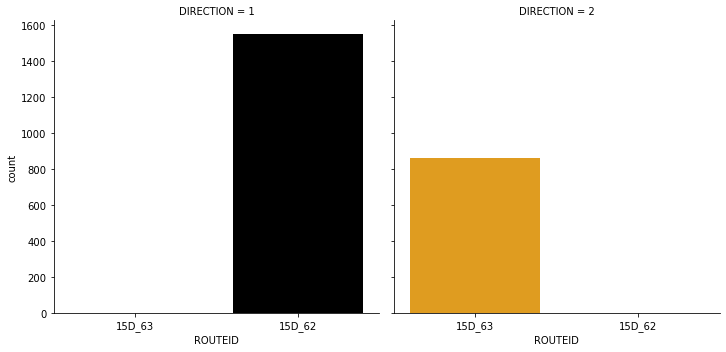

<Figure size 432x288 with 0 Axes>

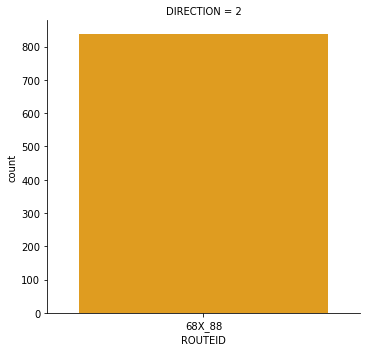

<Figure size 432x288 with 0 Axes>

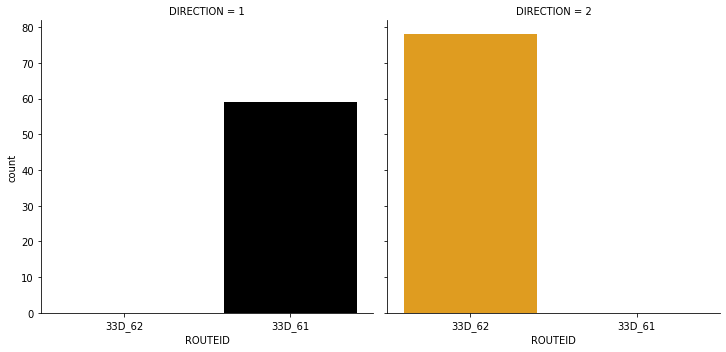

In [39]:
# plot counts of entries for ROUTEID of a particular LINEID

df_dominant_route = pd.DataFrame(columns=["LINEID","DOMINANT_ROUTEID","DIRECTION"])
with PdfPages('LINEID_Route_counts.pdf') as pp:
    for Line in list(df_Jan_trips.LINEID.unique()):
        
        # dataframe dominant_route is used to record dominant route for each LINEID
        df_line = df_Jan_trips.loc[df_Jan_trips["LINEID"] == Line]
        try:
            dom_route_D1 = df_line[(df_line["DIRECTION"] == 1)]["ROUTEID"].value_counts(sort=True).keys()[0]
            df_dominant_route.loc[len(df_dominant_route)] = [Line,dom_route_D1,1]
        except:
            print("error in line",Line,"direction 2")
        
        try:
            dom_route_D2 = df_line[(df_line["DIRECTION"] == 2)]["ROUTEID"].value_counts(sort=True).keys()[0]            
            df_dominant_route.loc[len(df_dominant_route)] = [Line,dom_route_D2,2]
        except:
            print("error in line",Line,"direction 2")
            
        plt.figure()
        sns.catplot(x="ROUTEID",col="DIRECTION",kind="count",palette=sns.color_palette(['orange', 'black']), \
                data=df_line)
        pp.savefig()

In [40]:
df_dominant_route.to_csv('../DB/dominant_route.csv', index=False)

**AS SHOWN, MAJORITY OF LINEID HAS A SINGLE DOMINANT ROUTEID IN EITHER DIRECTION**
* **Thus, non dominant ROUTEIDs for them can be safely dropped**
* **Even for LINEIDs having multiple ROUTEIDs with considerable observation points; same strategy is observed**

### Varify if STOPIDs visited for a ROUTEID for a LINEID in different trips are different thoughout database

In [41]:
df_41_3 =  df_Jan_trips_41.loc[(df_Jan_trips_41['ROUTEID'] == '41_3')].sort_values(by = 'PROGRNUMBER')

In [42]:
df_41_3

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,DIRECTION,ROUTEID
7039666,2018-01-23,6216050,1,288,21600,21600,21581,21581,41,1,41_3
8396578,2018-01-26,6212621,1,288,66300,66300,66514,66514,41,1,41_3
4752227,2018-01-16,6115930,1,288,19800,19800,19783,19783,41,1,41_3
2794890,2018-01-09,6098110,1,288,76500,76500,76500,76500,41,1,41_3
1700955,2018-01-06,5972065,1,288,38400,38400,38357,38357,41,1,41_3
...,...,...,...,...,...,...,...,...,...,...,...
4324376,2018-01-14,6112919,51,4957,68636,68636,68737,68737,41,1,41_3
9813327,2018-01-31,6231183,51,4957,47131,47131,47595,47595,41,1,41_3
8999146,2018-01-29,6245143,51,4957,31490,31490,31762,31762,41,1,41_3
4195780,2018-01-14,6109174,51,4957,26496,26496,26293,26293,41,1,41_3


#### Take unique values into dictionary

In [43]:
uniques = {}
for col in df_41_3.columns:
    uniques[col] = df_41_3[col].unique()

In [44]:
uniques['ROUTEID']

array(['41_3'], dtype=object)

####  View DAYOFSERVICE  when ROUTE 41_3 was served

In [45]:
DAYOFSERVICE_41_3 = list(uniques['DAYOFSERVICE'])

In [46]:
print("Days of service: ",len(DAYOFSERVICE_41_3))
print("5 entries as example: ", DAYOFSERVICE_41_3[:5])

Days of service:  31
5 entries as example:  [numpy.datetime64('2018-01-23T00:00:00.000000000'), numpy.datetime64('2018-01-26T00:00:00.000000000'), numpy.datetime64('2018-01-16T00:00:00.000000000'), numpy.datetime64('2018-01-09T00:00:00.000000000'), numpy.datetime64('2018-01-06T00:00:00.000000000')]


####  View TRIPIDs used to serve ROUTE 41_3

In [47]:
TRIPID_41_3 = list(uniques['TRIPID'])

In [48]:
print("No of TRIPIDs: ",len(TRIPID_41_3))
print("5 entries as example: ", TRIPID_41_3[:5])

No of TRIPIDs:  574
5 entries as example:  [6216050, 6212621, 6115930, 6098110, 5972065]


#### Make dictionary of variants of STOPPOINTIDs visited during each of the TRIP on Route 41_3
* **To confirm that stops visited during trips on same ROUTEID may be different; STOPPOINTIDs are grouped for each TRIPID on each DAYOFSERVICE for ROUTEID 41_3 data**
* **VARIATIONS AND FREQUENCY IS OBSERVED FOR THE OCCURANCES**

In [49]:
import collections

STOPS_trips_41_3 = {}
trip_dayOfService_41_3 = list(df_41_3.reset_index(drop=True).groupby(['DAYOFSERVICE','TRIPID'])['STOPPOINTID'].apply(tuple))
print("Number of trips made on Route 41_3: ", len(trip_dayOfService_41_3),"\n\n")

set_41_3_stopList = list(set(tuple(row) for row in trip_dayOfService_41_3))
print("Number of ruote variations available for Route 41_3: ", len(set_41_3_stopList),"\n\n")

for stopList in set_41_3_stopList:
    STOPS_trips_41_3[stopList] = trip_dayOfService_41_3.count(stopList)
    
STOPS_trips_41_3 = {k: v for k, v in sorted(STOPS_trips_41_3.items(), key=lambda item: item[1],reverse=True)}


for (x, y) in STOPS_trips_41_3.items():
    print("Variation of Stops visited during route 41_3: ",x,"\nNumber of occurance for this vaiant: ", y,"\n")

Number of trips made on Route 41_3:  1423 


Number of ruote variations available for Route 41_3:  59 


Variation of Stops visited during route 41_3:  (288, 1171, 1172, 1173, 1174, 1175, 15, 17, 18, 19, 21, 7602, 85, 203, 204, 205, 1620, 220, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 7348, 3669, 3671, 3672, 3674, 3675, 3676, 5073, 5074, 6054, 4330, 3679, 5075, 5076, 3682, 3864, 3865, 4910, 4911, 4912, 4913, 4914, 4915, 4957) 
Number of occurance for this vaiant:  1254 

Variation of Stops visited during route 41_3:  (1173, 1174, 1175, 15, 17, 18, 19, 21, 7602, 85, 203, 204, 205, 1620, 220, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 7348, 3669, 3671, 3672, 3674, 3675, 3676, 5073, 5074, 6054, 4330, 3679, 5075, 5076, 3682, 3864, 3865, 4910, 4911, 4912, 4913, 4914, 4915, 4957) 
Number of occurance for this vaiant:  45 

Variation of Stops visited during route 41_3:  (288, 1171, 1172, 1173, 1174, 1175, 15, 17, 18, 19, 21, 7602, 85, 203, 204, 205, 1620, 220, 1622, 162

In [50]:
print("Number of vairants available for Route 41_3: ", len(STOPS_trips_41_3),"\n\n")
print("Most frequented variant for ROUTE 41_3: \n",next(iter(STOPS_trips_41_3)))

Number of vairants available for Route 41_3:  59 


Most frequented variant for ROUTE 41_3: 
 (288, 1171, 1172, 1173, 1174, 1175, 15, 17, 18, 19, 21, 7602, 85, 203, 204, 205, 1620, 220, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 7348, 3669, 3671, 3672, 3674, 3675, 3676, 5073, 5074, 6054, 4330, 3679, 5075, 5076, 3682, 3864, 3865, 4910, 4911, 4912, 4913, 4914, 4915, 4957)


**OBSERVATIONS FROM ABOVE SETS**<BR>
* **EVEN FOR A SINGLE ROUTE; STOPS VISITED DURING DIFFERENT TRIPS MAY VARY PARTIALLY**
    * **Though for ROUTEID 41_3, more than 88% occurances [1254 out of total 1423] follow a single STOPOINTID sequence**

<br><br>

### Drop insignificant ROUTEIDS
**From above anlysis; We have obtained source of truth stating that:**
* **For a LINEID; ROUTEIDs and TRIPIDs used for DIFFERENT DIRECTION are mutually exclusive**
* **EVEN FOR ROUTEIDs HAVING SAME DIRECTION; STOPPOINTIDs VISITED ARE DIFFERENT**
* **ROUTEIDs ARE NOT KNOWN TO USER & ROUTEIDs ARE NOT TIMEBOUND i.e. timetable DOES NOT exists to follow a ROUTEID**
* **majority of data for a LINEID is tied with a particular ROUTEID**

**Hence, we can safely drop data for insignificant ROUTEIDs** 

In [51]:
df_dominant_route_list = pd.read_csv('../DB/dominant_route.csv')
dominant_route_list = list(df_dominant_route_list["DOMINANT_ROUTEID"])
df_Jan_trips_dom_Route = df_Jan_trips.loc[df_Jan_trips['ROUTEID'].isin(dominant_route_list)]

In [52]:
dominant_route_list

['41_3',
 '41_7',
 '66_11',
 '66_13',
 '77A_29',
 '77A_28',
 '83_16',
 '83_22',
 '130_10',
 '130_11',
 '151_15',
 '151_17',
 '40_27',
 '40_31',
 '122_14',
 '122_16',
 '13_60',
 '13_67',
 '65_74',
 '65_77',
 '41C_78',
 '41C_79',
 '75_17',
 '75_19',
 '33_44',
 '33_70',
 '15_16',
 '15_17',
 '7A_85',
 '7A_87',
 '27A_4',
 '27A_5',
 '67_4',
 '67_6',
 '15B_60',
 '15B_61',
 '150_8',
 '150_9',
 '39A_40',
 '39A_43',
 '123_34',
 '123_36',
 '16_20',
 '16_24',
 '27_19',
 '27_17',
 '29A_14',
 '29A_15',
 '7_66',
 '7_70',
 '145_102',
 '145_105',
 '4_10',
 '4_12',
 '39_20',
 '39_21',
 '38_9',
 '38_14',
 '46A_74',
 '46A_67',
 '18_3',
 '18_4',
 '65B_65',
 '65B_66',
 '25A_273',
 '25A_270',
 '14_15',
 '14_16',
 '25B_274',
 '25B_271',
 '31_15',
 '31_18',
 '31A_25',
 '31A_26',
 '27B_23',
 '27B_34',
 '84_27',
 '84_30',
 '40D_102',
 '40D_104',
 '15A_83',
 '15A_84',
 '17A_15',
 '17A_17',
 '54A_11',
 '54A_12',
 '38A_20',
 '38A_32',
 '9_5',
 '9_7',
 '37_14',
 '37_15',
 '33B_56',
 '33B_58',
 '70_60',
 '70_67',
 '1

#### Object types and valid entries

In [53]:
df_Jan_trips_dom_Route.info(null_counts= True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9167511 entries, 0 to 10034020
Data columns (total 11 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   DAYOFSERVICE     9167511 non-null  datetime64[ns]
 1   TRIPID           9167511 non-null  int32         
 2   PROGRNUMBER      9167511 non-null  int8          
 3   STOPPOINTID      9167511 non-null  int16         
 4   PLANNEDTIME_ARR  9167511 non-null  int32         
 5   PLANNEDTIME_DEP  9167511 non-null  int32         
 6   ACTUALTIME_ARR   9167511 non-null  int32         
 7   ACTUALTIME_DEP   9167511 non-null  int32         
 8   LINEID           9167511 non-null  object        
 9   DIRECTION        9167511 non-null  int8          
 10  ROUTEID          9167511 non-null  object        
dtypes: datetime64[ns](1), int16(1), int32(5), int8(2), object(2)
memory usage: 489.6+ MB


#### Unique entries

In [54]:
df_Jan_trips_dom_Route.nunique()

DAYOFSERVICE          31
TRIPID             69355
PROGRNUMBER          102
STOPPOINTID         4097
PLANNEDTIME_ARR    67720
PLANNEDTIME_DEP    67720
ACTUALTIME_ARR     70061
ACTUALTIME_DEP     70060
LINEID               126
DIRECTION              2
ROUTEID              246
dtype: int64

$\Large Analysis\ of\ sample\ size\ after\ dropping\ data$
* **COUNT OF ENTRIES FOR ORIGINAL DATA df_Jan_trips = $10034307$ | with count of ROUTEIDs = $498$**
* **COUNT OF ENTRIES FOR ORIGINAL DATA AFTER OMMITING NON SIGNIFICANT ROUTEIDS = $9167511$ | with count of ROUTEIDs = $246$**
* **AFTER DROPPING DATA FOR NON SIGNIFICANT ROUTEIDS [which are roughly $50\%$ of total ROUTEIDs]; WE ARE STILL LEFT WITH $\Large 91\%$ OF DATA (9167511/10034307 * 100)**
<br>

**THIS IS SIGNIFICANT SIZE OF DATA SIZE TO TRAIN ON; AS WE HAVE REDUCED CARDINALITY OF ROUTEID FEATURE BY $50\%$ LOOSING ONLY $9\%$ OF DATA**

#### Save data to csv

In [55]:
df_Jan_trips_dom_Route.to_csv("../DB/ML/imp_ROUTEID_Jan_trips_MERGED.csv",index=False)

## Check nature of Arrival and departure times
* [Documentation on Dublin Bus data](https://brightspace.ucd.ie/d2l/le/content/54595/viewContent/922112/View) defines 
    * PlannedTime_Arr : Planned arrival time at the stop point, in seconds 
    * PlannedTime_Dep: Planned departure time from the stop point, in seconds
    * ActualTime_Arr: Actual arrival time at the stop point, in seconds
    * ActualTime_Dep: Actual departure time from the stop point, in seconds
* **Value in seconds** is **offset in seconds from 00:00:00 for particular date**

**EXTENDED TIMES**<br>
* FOR LATE NIGHT TRIPS WHICH TECHNICALLY SPAN OVER 2 DAYS; **EXTENDED TIMES** ARE USED<br>
For example a trip starting at 23:30 of 1st ofApril and ending at 00:30 of the 2nd of April could have the last AVL data tracked at “24:30of 1st of April”. To express this “extended time” the interface requires the use of secondspast the beginning of the operation day. In our example the DayOfService is “01/04/2014”and the extended time is “88200” (= 24*60*60 + 30*6)

In [56]:
import pandas as pd

In [57]:
df_Jan_trips_dom_Route = pd.read_csv("../DB/ML/imp_ROUTEID_Jan_trips_MERGED.csv")

In [58]:
df_Jan_trips_dom_Route['DAYOFSERVICE'] = pd.to_datetime(df_Jan_trips_dom_Route['DAYOFSERVICE'])
df_Jan_trips_dom_Route['TRIPID'] = pd.to_numeric(df_Jan_trips_dom_Route['TRIPID'], downcast='integer', errors='coerce')
df_Jan_trips_dom_Route['PROGRNUMBER'] = pd.to_numeric(df_Jan_trips_dom_Route['PROGRNUMBER'], downcast='integer', errors='coerce')
df_Jan_trips_dom_Route['STOPPOINTID'] = pd.to_numeric(df_Jan_trips_dom_Route['STOPPOINTID'], downcast='integer', errors='coerce')
df_Jan_trips_dom_Route['PLANNEDTIME_ARR'] = pd.to_numeric(df_Jan_trips_dom_Route['PLANNEDTIME_ARR'], downcast='integer', errors='coerce')
df_Jan_trips_dom_Route['PLANNEDTIME_DEP'] = pd.to_numeric(df_Jan_trips_dom_Route['PLANNEDTIME_DEP'], downcast='integer', errors='coerce')
df_Jan_trips_dom_Route['ACTUALTIME_ARR'] = pd.to_numeric(df_Jan_trips_dom_Route['ACTUALTIME_ARR'], downcast='integer', errors='coerce')
df_Jan_trips_dom_Route['ACTUALTIME_DEP'] = pd.to_numeric(df_Jan_trips_dom_Route['ACTUALTIME_DEP'], downcast='integer', errors='coerce')
df_Jan_trips_dom_Route['LINEID'] = df_Jan_trips_dom_Route['LINEID'].astype('str')
df_Jan_trips_dom_Route['ROUTEID'] = df_Jan_trips_dom_Route['ROUTEID'].astype('str')
df_Jan_trips_dom_Route['DIRECTION'] = pd.to_numeric(df_Jan_trips_dom_Route['DIRECTION'], downcast='integer', errors='coerce')

In [59]:
df_Jan_trips_dom_Route.head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,DIRECTION,ROUTEID
0,2018-01-01,5958355,3,1172,23799,23799,23863,23863,41,1,41_3
1,2018-01-01,5958355,4,1173,23860,23860,23934,24072,41,1,41_3
2,2018-01-01,5958355,5,1174,23937,23937,24114,24140,41,1,41_3
3,2018-01-01,5958355,6,1175,24048,24048,24180,24192,41,1,41_3
4,2018-01-01,5958355,7,15,24130,24130,24227,24257,41,1,41_3


In [60]:
df_Jan_trips_dom_Route.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9167511 entries, 0 to 9167510
Data columns (total 11 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   DAYOFSERVICE     9167511 non-null  datetime64[ns]
 1   TRIPID           9167511 non-null  int32         
 2   PROGRNUMBER      9167511 non-null  int8          
 3   STOPPOINTID      9167511 non-null  int16         
 4   PLANNEDTIME_ARR  9167511 non-null  int32         
 5   PLANNEDTIME_DEP  9167511 non-null  int32         
 6   ACTUALTIME_ARR   9167511 non-null  int32         
 7   ACTUALTIME_DEP   9167511 non-null  int32         
 8   LINEID           9167511 non-null  object        
 9   DIRECTION        9167511 non-null  int8          
 10  ROUTEID          9167511 non-null  object        
dtypes: datetime64[ns](1), int16(1), int32(5), int8(2), object(2)
memory usage: 419.7+ MB


### Check Entries containing Exteded Time
**All TIME feature entries greater than “86400” (=24*60*60) are extended time entries**

In [61]:
df_Jan_trips_dom_Route_extendedTime = df_Jan_trips_dom_Route.loc[(df_Jan_trips_dom_Route['PLANNEDTIME_ARR'] > 86400) |
                                             (df_Jan_trips_dom_Route['PLANNEDTIME_DEP'] > 86400) |
                                             (df_Jan_trips_dom_Route['ACTUALTIME_ARR'] > 86400) |
                                             (df_Jan_trips_dom_Route['ACTUALTIME_DEP'] > 86400)
                                            ]
df_Jan_trips_dom_Route_extendedTime.head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,DIRECTION,ROUTEID
162468,2018-01-01,5960398,83,1280,86202,86202,86443,86443,40,2,40_31
162469,2018-01-01,5960398,84,6348,86257,86257,86565,86565,40,2,40_31
162708,2018-01-01,5961860,71,2601,85882,85882,86439,86439,27,1,27_19
162709,2018-01-01,5961860,72,4446,85931,85931,86471,86471,27,1,27_19
162710,2018-01-01,5961860,73,2603,86002,86002,86513,86522,27,1,27_19


In [62]:
df_Jan_trips_dom_Route_extendedTime.nunique()

DAYOFSERVICE         31
TRIPID              908
PROGRNUMBER         102
STOPPOINTID        1233
PLANNEDTIME_ARR    2608
PLANNEDTIME_DEP    2608
ACTUALTIME_ARR     3206
ACTUALTIME_DEP     3207
LINEID               61
DIRECTION             2
ROUTEID              96
dtype: int64

### Check Entries where all TIME features are in extended format 

In [63]:
df_Jan_trips_dom_Route_extendedTime_all = df_Jan_trips_dom_Route.loc[(df_Jan_trips_dom_Route['PLANNEDTIME_ARR'] > 86400) &
                                             (df_Jan_trips_dom_Route['PLANNEDTIME_DEP'] > 86400) &
                                             (df_Jan_trips_dom_Route['ACTUALTIME_ARR'] > 86400) &
                                             (df_Jan_trips_dom_Route['ACTUALTIME_DEP'] > 86400)
                                            ]
df_Jan_trips_dom_Route_extendedTime_all.head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,DIRECTION,ROUTEID
162718,2018-01-01,5961860,81,2621,86450,86450,87023,87036,27,1,27_19
162719,2018-01-01,5961860,82,2622,86481,86481,87081,87081,27,1,27_19
162720,2018-01-01,5961860,83,2623,86509,86509,87106,87121,27,1,27_19
162721,2018-01-01,5961860,84,2624,86567,86567,87163,87163,27,1,27_19
162722,2018-01-01,5961860,85,4441,86610,86610,87199,87207,27,1,27_19


In [64]:
df_Jan_trips_dom_Route_extendedTime_all.shape

(14713, 11)

In [65]:
df_Jan_trips_dom_Route_extendedTime_all.nunique()

DAYOFSERVICE         31
TRIPID              637
PROGRNUMBER         102
STOPPOINTID         851
PLANNEDTIME_ARR    1749
PLANNEDTIME_DEP    1749
ACTUALTIME_ARR     2368
ACTUALTIME_DEP     2383
LINEID               54
DIRECTION             2
ROUTEID              75
dtype: int64

### Entries where few of the TIME features is in Extended Time but not all

In [66]:
df_Jan_trips_dom_Route_extendedTime_few = df_Jan_trips_dom_Route_extendedTime[~ df_Jan_trips_dom_Route_extendedTime.isin(df_Jan_trips_dom_Route_extendedTime_all)].dropna()

In [67]:
df_Jan_trips_dom_Route_extendedTime_few.head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,DIRECTION,ROUTEID
162468,2018-01-01,5960398.0,83.0,1280.0,86202.0,86202.0,86443.0,86443.0,40,2.0,40_31
162469,2018-01-01,5960398.0,84.0,6348.0,86257.0,86257.0,86565.0,86565.0,40,2.0,40_31
162708,2018-01-01,5961860.0,71.0,2601.0,85882.0,85882.0,86439.0,86439.0,27,1.0,27_19
162709,2018-01-01,5961860.0,72.0,4446.0,85931.0,85931.0,86471.0,86471.0,27,1.0,27_19
162710,2018-01-01,5961860.0,73.0,2603.0,86002.0,86002.0,86513.0,86522.0,27,1.0,27_19


In [68]:
df_Jan_trips_dom_Route_extendedTime_few.shape

(9564, 11)

In [69]:
df_Jan_trips_dom_Route_extendedTime_few.nunique()

DAYOFSERVICE         31
TRIPID              864
PROGRNUMBER          86
STOPPOINTID        1058
PLANNEDTIME_ARR    1425
PLANNEDTIME_DEP    1425
ACTUALTIME_ARR     1620
ACTUALTIME_DEP     1624
LINEID               61
DIRECTION             2
ROUTEID              96
dtype: int64

### Check if arrival time for buses are early/ late than planned time

In [70]:
df_Jan_trips_dom_Route_early_late = df_Jan_trips_dom_Route.copy()

In [71]:
df_Jan_trips_dom_Route_early_late.loc[df_Jan_trips_dom_Route_early_late['PLANNEDTIME_ARR'] > df_Jan_trips_dom_Route_early_late['ACTUALTIME_ARR']]

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,DIRECTION,ROUTEID
24,2018-01-01,5958355,27,1630,25279,25279,25246,25257,41,1,41_3
25,2018-01-01,5958355,28,7348,25508,25508,25487,25537,41,1,41_3
26,2018-01-01,5958355,29,3669,25615,25615,25611,25622,41,1,41_3
27,2018-01-01,5958355,30,3671,25677,25677,25664,25679,41,1,41_3
28,2018-01-01,5958355,31,3672,25708,25708,25707,25707,41,1,41_3
...,...,...,...,...,...,...,...,...,...,...,...
9167506,2018-01-31,6232035,16,3726,86812,86812,86671,86671,33B,1,33B_56
9167507,2018-01-31,6232035,17,7039,86848,86848,86685,86685,33B,1,33B_56
9167508,2018-01-31,6232035,18,7204,86890,86890,86722,86761,33B,1,33B_56
9167509,2018-01-31,6232035,19,3728,86988,86988,86836,86836,33B,1,33B_56


### Check if departure time for buses are early/ late than planned time

In [72]:
df_Jan_trips_dom_Route_early_late.loc[df_Jan_trips_dom_Route_early_late['PLANNEDTIME_DEP'] > df_Jan_trips_dom_Route_early_late['ACTUALTIME_DEP']]

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,DIRECTION,ROUTEID
24,2018-01-01,5958355,27,1630,25279,25279,25246,25257,41,1,41_3
28,2018-01-01,5958355,31,3672,25708,25708,25707,25707,41,1,41_3
30,2018-01-01,5958355,33,3675,25822,25822,25816,25816,41,1,41_3
33,2018-01-01,5958355,36,5074,25999,25999,25976,25987,41,1,41_3
34,2018-01-01,5958355,37,6054,26030,26030,26025,26025,41,1,41_3
...,...,...,...,...,...,...,...,...,...,...,...
9167506,2018-01-31,6232035,16,3726,86812,86812,86671,86671,33B,1,33B_56
9167507,2018-01-31,6232035,17,7039,86848,86848,86685,86685,33B,1,33B_56
9167508,2018-01-31,6232035,18,7204,86890,86890,86722,86761,33B,1,33B_56
9167509,2018-01-31,6232035,19,3728,86988,86988,86836,86836,33B,1,33B_56


### Plot early/ late arrival and departures

In [73]:
df_Jan_trips_dom_Route_early_late['Arrival_lateEarly'] = df_Jan_trips_dom_Route_early_late['PLANNEDTIME_ARR'].ge(df_Jan_trips_dom_Route_early_late['ACTUALTIME_ARR'])
df_Jan_trips_dom_Route_early_late['departure_lateEarly'] = df_Jan_trips_dom_Route_early_late['PLANNEDTIME_DEP'].ge(df_Jan_trips_dom_Route_early_late['ACTUALTIME_DEP'])

In [74]:
df_Jan_trips_dom_Route_early_late[df_Jan_trips_dom_Route_early_late['Arrival_lateEarly'] == True]

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,DIRECTION,ROUTEID,Arrival_lateEarly,departure_lateEarly
24,2018-01-01,5958355,27,1630,25279,25279,25246,25257,41,1,41_3,True,True
25,2018-01-01,5958355,28,7348,25508,25508,25487,25537,41,1,41_3,True,False
26,2018-01-01,5958355,29,3669,25615,25615,25611,25622,41,1,41_3,True,False
27,2018-01-01,5958355,30,3671,25677,25677,25664,25679,41,1,41_3,True,False
28,2018-01-01,5958355,31,3672,25708,25708,25707,25707,41,1,41_3,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167506,2018-01-31,6232035,16,3726,86812,86812,86671,86671,33B,1,33B_56,True,True
9167507,2018-01-31,6232035,17,7039,86848,86848,86685,86685,33B,1,33B_56,True,True
9167508,2018-01-31,6232035,18,7204,86890,86890,86722,86761,33B,1,33B_56,True,True
9167509,2018-01-31,6232035,19,3728,86988,86988,86836,86836,33B,1,33B_56,True,True


### Check relation between planned arrival and departures

In [75]:
df_Jan_trips_dom_Route_early_late['planned_arr_dep_equality'] = df_Jan_trips_dom_Route_early_late['PLANNEDTIME_ARR'].eq(df_Jan_trips_dom_Route_early_late['PLANNEDTIME_DEP'])

In [76]:
df_Jan_trips_dom_Route_early_late[df_Jan_trips_dom_Route_early_late['planned_arr_dep_equality'] == True]

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,PLANNEDTIME_DEP,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,DIRECTION,ROUTEID,Arrival_lateEarly,departure_lateEarly,planned_arr_dep_equality
0,2018-01-01,5958355,3,1172,23799,23799,23863,23863,41,1,41_3,False,False,True
1,2018-01-01,5958355,4,1173,23860,23860,23934,24072,41,1,41_3,False,False,True
2,2018-01-01,5958355,5,1174,23937,23937,24114,24140,41,1,41_3,False,False,True
3,2018-01-01,5958355,6,1175,24048,24048,24180,24192,41,1,41_3,False,False,True
4,2018-01-01,5958355,7,15,24130,24130,24227,24257,41,1,41_3,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9167506,2018-01-31,6232035,16,3726,86812,86812,86671,86671,33B,1,33B_56,True,True,True
9167507,2018-01-31,6232035,17,7039,86848,86848,86685,86685,33B,1,33B_56,True,True,True
9167508,2018-01-31,6232035,18,7204,86890,86890,86722,86761,33B,1,33B_56,True,True,True
9167509,2018-01-31,6232035,19,3728,86988,86988,86836,86836,33B,1,33B_56,True,True,True


$\Large Analysis\ of\ sample\ size\ after\ dropping\ data$
* **COUNT OF ENTRIES FOR ORIGINAL DATA IN df_Jan_trips_dom_Route : $9600545$**
* **COUNT OF ENTRIES FOR DATA HAVING PLANNEDTIME_ARR == PLANNEDTIME_DEP : $9600545$**
<br>

$PLANNED\ ARRIVAL\ AND\ DEPARTURE\ TIMES\ ARE\ SAME\ FOR\ ALL\ ENTRIES.$
$ HENCE\ "PLANNEDTIME\_DEP"\ CAN\ BE\ DROPPED$

In [77]:
df_Jan_trips_dom_Route.drop(["PLANNEDTIME_DEP"],inplace=True,axis=1)

#### Save data to csv

In [78]:
df_Jan_trips_dom_Route.to_csv("../DB/ML/imp_ROUTEID_Jan_trips_MERGED.csv",index=False)

In [79]:
df_Jan_trips_dom_Route.head()

,DAYOFSERVICE,TRIPID,PROGRNUMBER,STOPPOINTID,PLANNEDTIME_ARR,ACTUALTIME_ARR,ACTUALTIME_DEP,LINEID,DIRECTION,ROUTEID
0,2018-01-01,5958355,3,1172,23799,23863,23863,41,1,41_3
1,2018-01-01,5958355,4,1173,23860,23934,24072,41,1,41_3
2,2018-01-01,5958355,5,1174,23937,24114,24140,41,1,41_3
3,2018-01-01,5958355,6,1175,24048,24180,24192,41,1,41_3
4,2018-01-01,5958355,7,15,24130,24227,24257,41,1,41_3
